In [146]:
# 1. Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct
from sklearn.model_selection import GridSearchCV, KFold

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense, GRU


In [147]:
#2. Read data
import yfinance as yf

data = yf.download(tickers = "NEM", start="2017-12-01", end="2023-06-11", interval='1d')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-01,37.070000,37.610001,36.779999,37.189999,31.313095,5074400
2017-12-04,37.240002,37.240002,36.660000,36.840000,31.018408,3777300
2017-12-05,36.599998,36.799999,36.070000,36.200001,30.479544,5984100
2017-12-06,36.250000,36.400002,35.779999,35.830002,30.168018,5797400
2017-12-07,35.529999,36.130001,35.450001,35.919998,30.307228,4047700
...,...,...,...,...,...,...
2023-06-05,41.700001,42.549999,41.580002,41.919998,41.919998,7459900
2023-06-06,41.970001,42.150002,41.599998,41.990002,41.990002,5477300
2023-06-07,42.000000,42.419998,41.570000,41.900002,41.900002,7056500


In [148]:
data = data.reset_index('Date', inplace=False)

In [149]:
df=data

# Descriptive Statistical

In [150]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1389.000000,1389.000000,1389.000000,1389.000000,1389.000000,1.389000e+03
mean,49.295623,49.964946,48.623283,49.302059,45.013225,7.413895e+06
std,12.875538,13.082052,12.657120,12.883232,12.787763,4.187551e+06
min,29.360001,29.830000,29.059999,29.600000,25.181959,1.857700e+06
25%,38.259998,38.650002,37.869999,38.290001,33.211258,5.029900e+06
50%,46.180000,46.910000,45.389999,46.169998,44.301849,6.404200e+06
75%,60.869999,61.500000,59.840000,60.610001,55.624874,8.702200e+06
max,85.550003,86.370003,85.099998,85.419998,81.046219,8.254290e+07


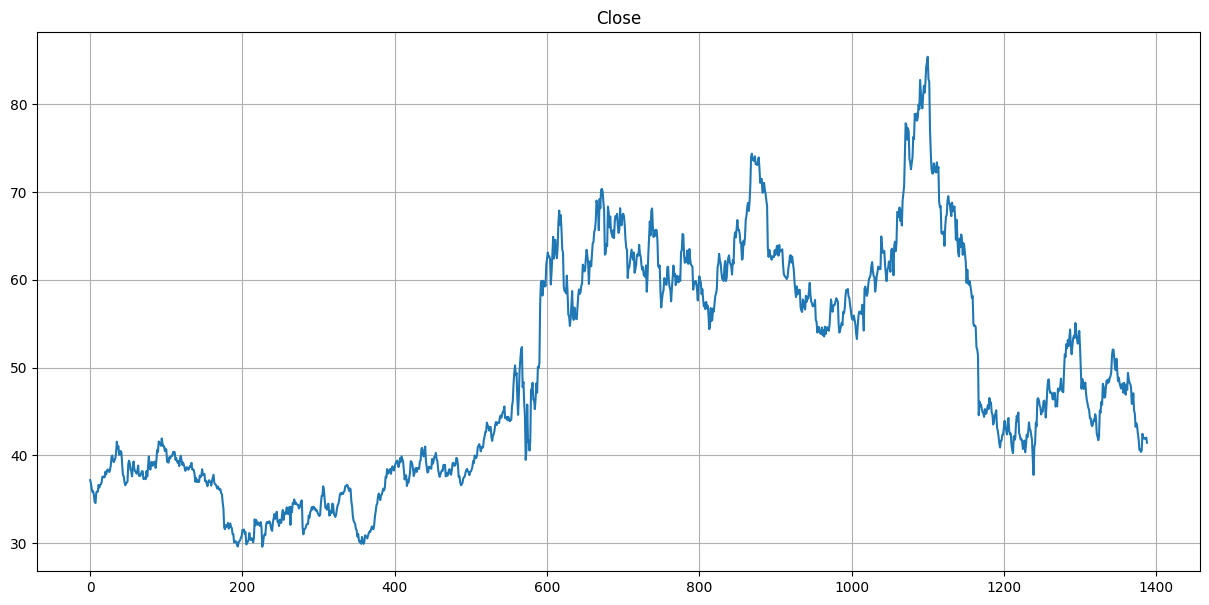

In [151]:
plt.figure(figsize=(15, 7))
plt.plot(data['Close'])
plt.title('Close')
plt.grid(True)
plt.show()

# 7:2:1

## Linear Regression

In [152]:
data = data[['Close']]
data = data.dropna() # Drop missing values
data = data.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [153]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

In [154]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [155]:
# Testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(x_test)

# Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(x_val)

In [156]:
# Predict for the next 7 days
last_index =  data.index[-1]
last_data1 = pd.RangeIndex(start=last_index, stop=last_index+7, step=1)

# Create an array of 7 consecutive integers starting from last_index
x_next_7_days = np.array(range(last_index+1, last_index+8)).reshape(-1, 1)

# Predict the closing prices for the next 7 days
y_next_7_days = model.predict(x_next_7_days)

# Print the predicted closing prices for the next 7 days
print('Predicted closing prices for the next 7 days:')
print(y_next_7_days)

Predicted closing prices for the next 7 days:
[81.5646904  81.60295182 81.64121324 81.67947467 81.71773609 81.75599752
 81.79425894]


In [157]:
# Predict for the next 30 days
last_index =  data.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(x_next_30_days)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[81.5646904  81.60295182 81.64121324 81.67947467 81.71773609 81.75599752
 81.79425894 81.83252036 81.87078179 81.90904321 81.94730464 81.98556606
 82.02382748 82.06208891 82.10035033 82.13861176 82.17687318 82.2151346
 82.25339603 82.29165745 82.32991888 82.3681803  82.40644172 82.44470315
 82.48296457 82.521226   82.55948742 82.59774884 82.63601027 82.67427169]


In [158]:
# Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
valid_mae = mean_absolute_error(y_val, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 18.645824370528242
Validation RMSE: 31.80375953387957
Testing MAE: 14.831154272501152
Validation MAE: 31.52361716672266
Testing MAPE: 0.3047594336683607
Validation MAPE: 0.6754091981748128


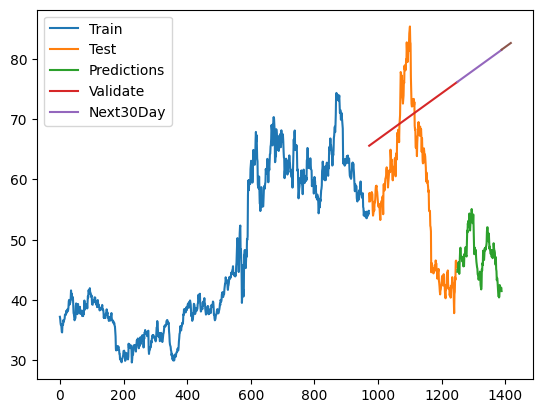

In [159]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

## Gated Recurrent Unit (GRU)

In [160]:
df = data

In [161]:
df1=df.reset_index()['Close']

In [162]:
#Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [163]:
#Split train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [164]:
#Function Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [165]:
#Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [166]:
#Reshape input to be [samples, time steps, features]
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [167]:
#Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [168]:
#Fit model with train data
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 8s 192ms/step - loss: 0.0216 - val_loss: 0.0077
Epoch 2/100
14/14 [==============================] - 2s 146ms/step - loss: 0.0043 - val_loss: 0.0056
Epoch 3/100
14/14 [==============================] - 2s 152ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 4/100
14/14 [==============================] - 2s 142ms/step - loss: 7.6727e-04 - val_loss: 0.0012
Epoch 5/100
14/14 [==============================] - 2s 115ms/step - loss: 6.6842e-04 - val_loss: 0.0012
Epoch 6/100
14/14 [==============================] - 2s 115ms/step - loss: 6.2321e-04 - val_loss: 0.0012
Epoch 7/100
14/14 [==============================] - 2s 113ms/step - loss: 6.0711e-04 - val_loss: 0.0012
Epoch 8/100
14/14 [==============================] - 2s 115ms/step - loss: 5.9826e-04 - val_loss: 0.0011
Epoch 9/100
14/14 [==============================] - 2s 115ms/step - loss: 5.8145e-04 - val_loss: 0.0011
Epoch 10/100
14/14 [==============================] - 2s 114ms/step

In [169]:
#Test, val
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 12ms/step


In [170]:
#Normalization y_pred, y_pred_val
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [171]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

yval = scaler.inverse_transform(yval.reshape(-1,1))

In [172]:
#Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(ytest, y_pred)
valid_mae = mean_absolute_error(yval, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(ytest, y_pred)
valid_mape = mean_absolute_percentage_error(yval, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 1.4198744023703551
Validation RMSE: 0.868656133845348
Testing MAE: 1.0343918150121516
Validation MAE: 0.6572320400140225
Testing MAPE: 0.018242945786940353
Validation MAPE: 0.01439504754894897


In [173]:
#Predict 7 days after
x_input=val_data[41:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output1=[]
n_steps=100
i=0

while i < 7:
    if len(temp_input) >= n_steps:
        x_input = np.array(temp_input[:n_steps])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output1.extend(yhat.tolist())
        i += 1
    else:
        padding = n_steps - len(temp_input)
        x_input = np.array(temp_input + [0] * padding)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        lst_output1.extend(yhat.tolist())
        i += 1

[0.05270405]
1 day input [0.40970981 0.42529561 0.43049089 0.42619133 0.45664638 0.43944826
 0.4249373  0.4145468  0.41795057 0.4405231  0.40899321 0.36277318
 0.32246504 0.34252959 0.33590109 0.32210681 0.32927266 0.33500537
 0.31189535 0.29917591 0.29111427 0.28341094 0.27893225 0.26209244
 0.26262986 0.2497313  0.24614834 0.25098532 0.2597635  0.25689715
 0.27051238 0.26191332 0.23109997 0.22500896 0.2174848  0.22500896
 0.27803653 0.27355785 0.29577214 0.28986025 0.33267643 0.32640631
 0.30455032 0.30526692 0.32586889 0.33948405 0.33339304 0.34145468
 0.33572197 0.34467934 0.34790399 0.35596563 0.38964527 0.40254389
 0.40218559 0.38498747 0.36402721 0.36026513 0.38373345 0.35686136
 0.33805091 0.34503764 0.33428876 0.32748121 0.32282335 0.32998927
 0.33321392 0.31440347 0.33446795 0.31888215 0.31046221 0.33070587
 0.32049448 0.35489072 0.34252959 0.33482625 0.3323182  0.32622719
 0.29165176 0.2927266  0.31332856 0.27803653 0.2714081  0.24489431
 0.25188105 0.24596922 0.23092085 0.2

In [174]:
scaler.inverse_transform(lst_output1)

array([[32.5419404 ],
       [34.71423014],
       [34.65095435],
       [34.62229278],
       [34.58800877],
       [34.54943318],
       [34.50897859]])

In [175]:
#Predict 30 days after
x_input=val_data[41:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0

while i < 30:
    if len(temp_input) >= n_steps:
        x_input = np.array(temp_input[:n_steps])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        padding = n_steps - len(temp_input)
        x_input = np.array(temp_input + [0] * padding)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

[0.05270405]
1 day input [0.40970981 0.42529561 0.43049089 0.42619133 0.45664638 0.43944826
 0.4249373  0.4145468  0.41795057 0.4405231  0.40899321 0.36277318
 0.32246504 0.34252959 0.33590109 0.32210681 0.32927266 0.33500537
 0.31189535 0.29917591 0.29111427 0.28341094 0.27893225 0.26209244
 0.26262986 0.2497313  0.24614834 0.25098532 0.2597635  0.25689715
 0.27051238 0.26191332 0.23109997 0.22500896 0.2174848  0.22500896
 0.27803653 0.27355785 0.29577214 0.28986025 0.33267643 0.32640631
 0.30455032 0.30526692 0.32586889 0.33948405 0.33339304 0.34145468
 0.33572197 0.34467934 0.34790399 0.35596563 0.38964527 0.40254389
 0.40218559 0.38498747 0.36402721 0.36026513 0.38373345 0.35686136
 0.33805091 0.34503764 0.33428876 0.32748121 0.32282335 0.32998927
 0.33321392 0.31440347 0.33446795 0.31888215 0.31046221 0.33070587
 0.32049448 0.35489072 0.34252959 0.33482625 0.3323182  0.32622719
 0.29165176 0.2927266  0.31332856 0.27803653 0.2714081  0.24489431
 0.25188105 0.24596922 0.23092085 0.2

In [176]:
scaler.inverse_transform(lst_output)

array([[32.5419404 ],
       [34.71423014],
       [34.65095435],
       [34.62229278],
       [34.58800877],
       [34.54943318],
       [34.50897859],
       [34.46752004],
       [34.42531705],
       [34.38246318],
       [34.33902125],
       [34.29505321],
       [34.25061896],
       [34.2057763 ],
       [34.16057889],
       [34.11507247],
       [34.0692953 ],
       [34.02327775],
       [33.97704269],
       [33.930608  ],
       [33.88398782],
       [33.83719047],
       [33.79022178],
       [33.74308548],
       [33.69578366],
       [33.64831506],
       [33.60068052],
       [33.55287921],
       [33.50490947],
       [33.45676879]])

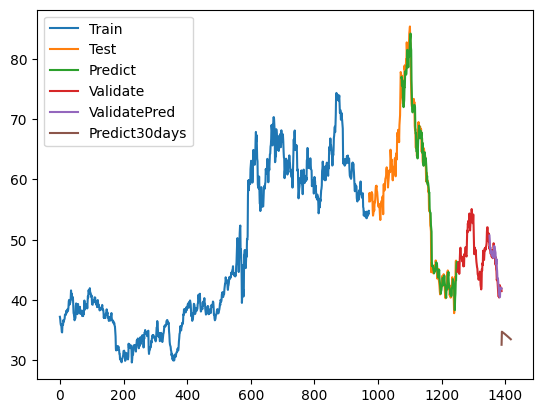

In [177]:
#Plot
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

## Autoregressive Integrated Moving Average (ARIMA)

In [178]:
data = data[['Close']]
data = data.dropna() # Drop missing values
data = data.reset_index(drop=True) # Reset the index

#Split the data into training, testing, and validation sets
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [179]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [180]:
#Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

#Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2800.030, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2801.758, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2801.748, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2798.336, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2797.141, Time=0.59 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2799.128, Time=0.96 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2803.715, Time=4.73 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2803.367, Time=0.38 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2803.427, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2795.440, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2800.043, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2800.054, Time=0.79 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2797.429, Time=0.91 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [181]:
#Testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

#Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [182]:
# Predict for the next 7 days
last_index =  data.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+7, step=1)

# Create an array of 7 consecutive integers starting from last_index
x_next_7_days = np.array(range(last_index+1, last_index+8)).reshape(-1, 1)

# Predict the closing prices for the next 7 days
y_next_7_days = model.predict(n_periods=len(x_next_7_days))

# Print the predicted closing prices for the next 7 days
print('Predicted closing prices for the next 7 days:')
print(y_next_7_days)

Predicted closing prices for the next 7 days:
[54.78368194 54.78019654 54.7834948  54.78037363 54.78332721 54.78053222
 54.78317714]


In [183]:
# Predict for the next 30 days
last_index =  data.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[54.78368194 54.78019654 54.7834948  54.78037363 54.78332721 54.78053222
 54.78317714 54.78067423 54.78304275 54.7808014  54.78292241 54.78091528
 54.78281464 54.78101726 54.78271814 54.78110859 54.78263172 54.78119037
 54.78255433 54.7812636  54.78248502 54.78132919 54.78242296 54.78138791
 54.78236739 54.7814405  54.78231762 54.7814876  54.78227306 54.78152977]


In [184]:
# Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
valid_mae = mean_absolute_error(y_val, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 12.547174242550739
Validation RMSE: 8.183257267304723
Testing MAE: 10.49308053559292
Validation MAE: 7.442658588530643
Testing MAPE: 0.1799451298755823
Validation MAPE: 0.16322486816429063


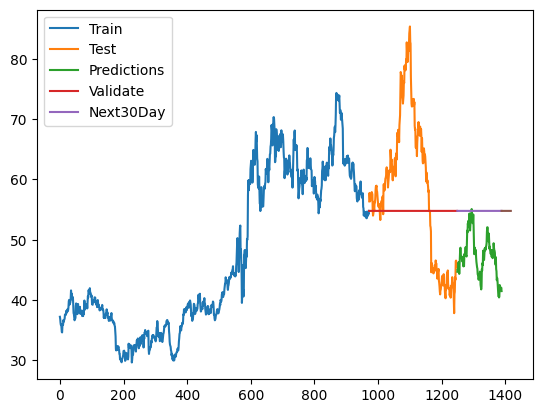

In [185]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

##Long short term memory (LSTM)

In [186]:
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Bidirectional

In [187]:
df1=df.reset_index()['Close']

In [188]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [189]:
#Split train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [190]:
#Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [191]:
#Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [192]:
#Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [193]:
#Define LSTM Model
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add a bidirectional LSTM layer
model.add(Bidirectional(LSTM(100, activation='relu')))

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [194]:
# Fit model with train data
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 10s 357ms/step - loss: 0.0704 - val_loss: 0.0728
Epoch 2/100
14/14 [==============================] - 5s 341ms/step - loss: 0.0126 - val_loss: 0.0338
Epoch 3/100
14/14 [==============================] - 5s 375ms/step - loss: 0.0068 - val_loss: 0.0246
Epoch 4/100
14/14 [==============================] - 4s 304ms/step - loss: 0.0046 - val_loss: 0.0216
Epoch 5/100
14/14 [==============================] - 4s 312ms/step - loss: 0.0037 - val_loss: 0.0182
Epoch 6/100
14/14 [==============================] - 6s 458ms/step - loss: 0.0031 - val_loss: 0.0148
Epoch 7/100
14/14 [==============================] - 4s 277ms/step - loss: 0.0027 - val_loss: 0.0079
Epoch 8/100
14/14 [==============================] - 4s 287ms/step - loss: 0.0024 - val_loss: 0.0062
Epoch 9/100
14/14 [==============================] - 5s 348ms/step - loss: 0.0023 - val_loss: 0.0050
Epoch 10/100
14/14 [==============================] - 4s 283ms/step - loss: 0.0023 - val_l

In [195]:
#Test, val
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 13ms/step


In [196]:
#Normalization y_pred, y_pred_val
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [197]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [198]:
#Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(ytest, y_pred)
valid_mae = mean_absolute_error(yval, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(ytest, y_pred)
valid_mape = mean_absolute_percentage_error(yval, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 2.270193607661857
Validation RMSE: 1.1310180780329748
Testing MAE: 1.839914625341242
Validation MAE: 0.9369857005583935
Testing MAPE: 0.030721071198702474
Validation MAPE: 0.020884965906966722


In [199]:
val_data.shape

(140, 1)

In [200]:
#Predict the next 7 days
x_input=val_data[40:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<7):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.22830965]
101
1 day input [0.40970981 0.42529561 0.43049089 0.42619133 0.45664638 0.43944826
 0.4249373  0.4145468  0.41795057 0.4405231  0.40899321 0.36277318
 0.32246504 0.34252959 0.33590109 0.32210681 0.32927266 0.33500537
 0.31189535 0.29917591 0.29111427 0.28341094 0.27893225 0.26209244
 0.26262986 0.2497313  0.24614834 0.25098532 0.2597635  0.25689715
 0.27051238 0.26191332 0.23109997 0.22500896 0.2174848  0.22500896
 0.27803653 0.27355785 0.29577214 0.28986025 0.33267643 0.32640631
 0.30455032 0.30526692 0.32586889 0.33948405 0.33339304 0.34145468
 0.33572197 0.34467934 0.34790399 0.35596563 0.38964527 0.40254389
 0.40218559 0.38498747 0.36402721 0.36026513 0.38373345 0.35686136
 0.33805091 0.34503764 0.33428876 0.32748121 0.32282335 0.32998927
 0.33321392 0.31440347 0.33446795 0.31888215 0.31046221 0.33070587
 0.32049448 0.35489072 0.34252959 0.33482625 0.3323182  0.32622719
 0.29165176 0.2927266  0.31332856 0.27803653 0.2714081  0.24489431
 0.25188105 0.24596922 0.23092085

In [201]:
#Predict the next 30 days
x_input=val_data[40:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.22830965]
101
1 day input [0.40970981 0.42529561 0.43049089 0.42619133 0.45664638 0.43944826
 0.4249373  0.4145468  0.41795057 0.4405231  0.40899321 0.36277318
 0.32246504 0.34252959 0.33590109 0.32210681 0.32927266 0.33500537
 0.31189535 0.29917591 0.29111427 0.28341094 0.27893225 0.26209244
 0.26262986 0.2497313  0.24614834 0.25098532 0.2597635  0.25689715
 0.27051238 0.26191332 0.23109997 0.22500896 0.2174848  0.22500896
 0.27803653 0.27355785 0.29577214 0.28986025 0.33267643 0.32640631
 0.30455032 0.30526692 0.32586889 0.33948405 0.33339304 0.34145468
 0.33572197 0.34467934 0.34790399 0.35596563 0.38964527 0.40254389
 0.40218559 0.38498747 0.36402721 0.36026513 0.38373345 0.35686136
 0.33805091 0.34503764 0.33428876 0.32748121 0.32282335 0.32998927
 0.33321392 0.31440347 0.33446795 0.31888215 0.31046221 0.33070587
 0.32049448 0.35489072 0.34252959 0.33482625 0.3323182  0.32622719
 0.29165176 0.2927266  0.31332856 0.27803653 0.2714081  0.24489431
 0.25188105 0.24596922 0.23092085

In [202]:
scaler.inverse_transform(lst_output)

array([[42.34424433],
       [42.4126568 ],
       [43.09488754],
       [43.4116246 ],
       [43.88786266],
       [44.31747514],
       [44.68389875],
       [45.08223454],
       [45.36379966],
       [45.67911022],
       [45.95049432],
       [46.21589458],
       [46.47285058],
       [46.71223268],
       [46.9349342 ],
       [47.12152304],
       [47.28201553],
       [47.41162226],
       [47.52022648],
       [47.60342139],
       [47.67184551],
       [47.71922219],
       [47.7515985 ],
       [47.7660316 ],
       [47.78081238],
       [47.77986914],
       [47.79477468],
       [47.79687244],
       [47.79994338],
       [47.76856521]])

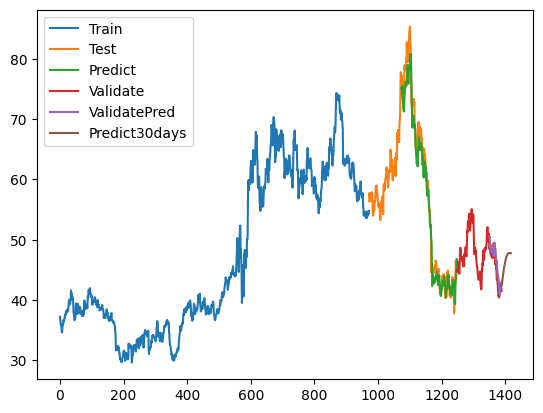

In [203]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

## Exponential Smoothing (ETS)

In [204]:
# 4. Split train test
data = data[['Close']]
data = data.dropna() # Drop missing values
data = data.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [205]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

In [206]:
pip install sktime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [207]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

In [208]:
simple_exp = ExponentialSmoothing(trend=None, seasonal=None)

In [209]:
#5. Fit model with train data
simple_exp.fit(y_train)

ExponentialSmoothing()

In [210]:
# 6. Testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])

# 7. Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])

In [211]:
y_pred = simple_exp.predict(test_data.index)

In [212]:
y_pred_val= simple_exp.predict(val_data.index)

In [213]:
#8. Predict next 7 days
last_index =  data.index[-1]
fh = list(range(last_index,last_index+7))
y_next_7_days = simple_exp.predict(fh)
y_next_7_days

array([[54.77999877],
       [54.77999877],
       [54.77999877],
       [54.77999877],
       [54.77999877],
       [54.77999877],
       [54.77999877]])

In [214]:
#9. Predict next 30 days
last_index =  data.index[-1]
fh = list(range(last_index,last_index+30))
y_next_30_days = simple_exp.predict(fh)
y_next_30_days

array([[54.77999877],
       [54.77999877],
       [54.77999877],
       [54.77999877],
       [54.77999877],
       [54.77999877],
       [54.77999877],
       [54.77999877],
       [54.77999877],
       [54.77999877],
       [54.77999877],
       [54.77999877],
       [54.77999877],
       [54.77999877],
       [54.77999877],
       [54.77999877],
       [54.77999877],
       [54.77999877],
       [54.77999877],
       [54.77999877],
       [54.77999877],
       [54.77999877],
       [54.77999877],
       [54.77999877],
       [54.77999877],
       [54.77999877],
       [54.77999877],
       [54.77999877],
       [54.77999877],
       [54.77999877]])

In [215]:
# 10. Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))

print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
valid_mae = mean_absolute_error(y_val, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 12.547717810833474
Validation RMSE: 8.181528480543488
Testing MAE: 10.493682533589716
Validation MAE: 7.440784527570037
Testing MAPE: 0.17994990228516097
Validation MAPE: 0.1631849907663381


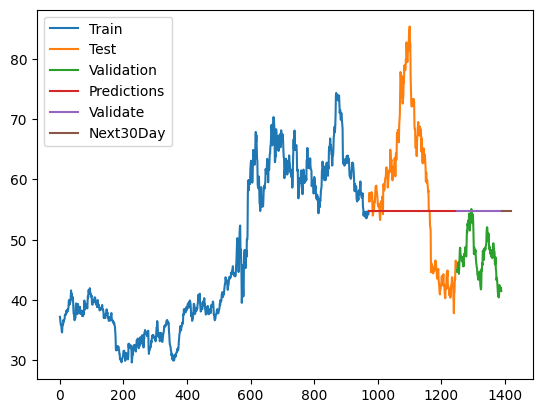

In [216]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(range(last_index+1, last_index+31),y_next_30_days)
plt.legend(['Train', 'Test', 'Validation', 'Predictions','Validate','Next30Day'])
plt.show()

## Random Forest

In [217]:
from sklearn.ensemble import RandomForestRegressor

In [218]:
data = data[['Close']]
data = data.dropna() # Drop missing values
data = data.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [219]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

In [220]:
# Testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])

# Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])

In [221]:
model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
model.fit(x_train, y_train)

RandomForestRegressor(max_depth=5, random_state=42)

In [222]:
y_pred = model.predict(x_test)

In [223]:
y_pred_val =  model.predict(x_val)

In [224]:
last_index =  data.index[-1]
# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(x_next_30_days)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[54.48796981 54.48796981 54.48796981 54.48796981 54.48796981 54.48796981
 54.48796981 54.48796981 54.48796981 54.48796981 54.48796981 54.48796981
 54.48796981 54.48796981 54.48796981 54.48796981 54.48796981 54.48796981
 54.48796981 54.48796981 54.48796981 54.48796981 54.48796981 54.48796981
 54.48796981 54.48796981 54.48796981 54.48796981 54.48796981 54.48796981]


In [225]:
# Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))

print('Testing RMSE:', test_rmse.item())
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
valid_mae = mean_absolute_error(y_val, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 12.634730809754025
Validation RMSE: 7.917033951975902
Testing MAE: 10.593346128151046
Validation MAE: 7.152927408883704
Testing MAPE: 0.1808101083370513
Validation MAPE: 0.15706027609825207


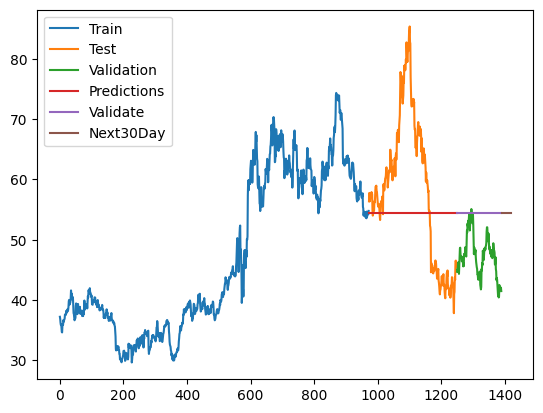

In [226]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(range(last_index+1, last_index+31),y_next_30_days)
plt.legend(['Train', 'Test', 'Validation', 'Predictions','Validate','Next30Day'])
plt.show()

## Bayesian Neural Networks (BNN)

In [227]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [228]:
train_dates = train_data.index.values
test_dates = test_data.index.values
val_dates = val_data.index.values
train_close_prices = train_data['Close'].values
val_close_prices = val_data['Close'].values
test_close_prices = test_data['Close'].values

In [229]:
import torch
import torch.nn as nn

In [230]:
X_train = torch.from_numpy(train_dates.reshape(-1, 1)).float()
y_train = torch.from_numpy(train_close_prices.reshape(-1, 1)).float()
X_test = torch.from_numpy(test_dates.reshape(-1, 1)).float()
y_test = torch.from_numpy(test_close_prices.reshape(-1, 1)).float()
X_val = torch.from_numpy(val_dates.reshape(-1, 1)).float()
y_val = torch.from_numpy(val_close_prices.reshape(-1, 1)).float()

In [231]:
# Determining the architecture of a Bayesian Neural Network.
class BNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(BNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [232]:
# Determining the loss function and optimization algorithm.
criterion = nn.MSELoss()
learning_rate = 0.001
num_epochs = 1000

In [233]:
# Built model BNN
model = BNN(input_size=1, output_size=1)

In [234]:
# Train model BNN
for epoch in range(num_epochs):
    model.train()

    # Tính đầu ra dự đoán của mô hình
    y_pred = model(X_train)

    # Tính lỗi dự đoán so với giá thực tế
    loss = criterion(y_pred, y_train)

    # Backpropagation và cập nhật trọng số
    loss.backward()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

Epoch [100/1000], Loss: 432.5575866699219
Epoch [200/1000], Loss: 345.1682434082031
Epoch [300/1000], Loss: 310.78369140625
Epoch [400/1000], Loss: 309.9154357910156
Epoch [500/1000], Loss: 335.69873046875
Epoch [600/1000], Loss: 292.92803955078125
Epoch [700/1000], Loss: 265.2786865234375
Epoch [800/1000], Loss: 280.0130310058594
Epoch [900/1000], Loss: 133.17578125
Epoch [1000/1000], Loss: 151.06690979003906


In [235]:
# Test
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test)

In [236]:
# Validation
model.eval()
with torch.no_grad():
    y_pred_val = model(X_val)

In [237]:
y_test = np.array(test_data['Close'])
y_val = np.array(val_data['Close'])

In [238]:
# Evaluating algorithm accuracy using
#RMSE
test_rmse = torch.sqrt(torch.mean((y_pred_test - y_test)**2))
valid_rmse = torch.sqrt(torch.mean((y_pred_val - y_val)**2))
#test_rmse = np.sqrt(np.mean((y_pred_test - y_test)**2))
#valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))

print('Testing RMSE:', test_rmse.item())
print('Validation RMSE:', valid_rmse.item())

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred_test)
valid_mae = mean_absolute_error(y_val, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred_test)
valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 33.51609707240794
Validation RMSE: 57.78081279989462
Testing MAE: 30.68970897137473
Validation MAE: 57.59797344207764
Testing MAPE: 0.6078244764318729
Validation MAPE: 1.229894603644424


In [239]:
# Predict the next 7 days
last_index =  data.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+7, step=1)

x_next_7_days = torch.from_numpy(np.array(range(last_index+1, last_index+8)).reshape(-1, 1)).float()

model.eval()
with torch.no_grad():
    y_pred_next = model(x_next_7_days)

# Chuyển đổi kết quả dự đoán thành mảng numpy
y_pred_next = y_pred_next.numpy().flatten()

# Hiển thị kết quả dự đoán
for i in range(len(x_next_7_days)):
    print(f'{y_pred_next[i]}')

110.30648040771484
110.38255310058594
110.45865631103516
110.53475952148438
110.61085510253906
110.68695068359375
110.76306915283203


In [240]:
# Predict the next 30 days
last_index =  data.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = torch.from_numpy(np.array(range(last_index+1, last_index+31)).reshape(-1, 1)).float()

model.eval()
with torch.no_grad():
    y_pred_next = model(x_next_30_days)

# Chuyển đổi kết quả dự đoán thành mảng numpy
y_pred_next = y_pred_next.numpy().flatten()

# Hiển thị kết quả dự đoán
for i in range(len(x_next_30_days)):
    print(f'{y_pred_next[i]}')

110.30648040771484
110.38255310058594
110.45865631103516
110.53475952148438
110.61085510253906
110.68695068359375
110.76306915283203
110.83914184570312
110.91523742675781
110.99134826660156
111.06742858886719
111.1435317993164
111.21963500976562
111.29572296142578
111.371826171875
111.44792175292969
111.52400970458984
111.60011291503906
111.67621612548828
111.75231170654297
111.82840728759766
111.90451049804688
111.9805908203125
112.05668640136719
112.1327896118164
112.20887756347656
112.28498077392578
112.361083984375
112.43717956542969
112.5132827758789


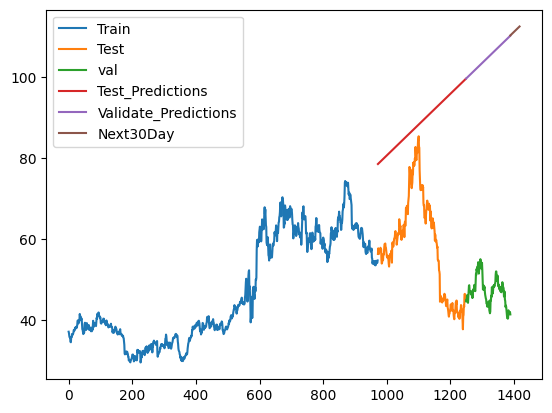

In [241]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred_test)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data, y_pred_next)
plt.legend(['Train', 'Test','val', 'Test_Predictions','Validate_Predictions','Next30Day'])
plt.show()

## Gaussian Process Regression (GPR)

In [242]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [243]:
# Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

In [244]:
# Testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])

# Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])

In [245]:
# Choose best kernel
kernels = [RBF(), Matern(), RationalQuadratic(), ExpSineSquared(), DotProduct()]
param_grid = {'kernel': kernels}

gpr = GaussianProcessRegressor()
grid_search = GridSearchCV(gpr, param_grid, cv=KFold(n_splits=5))

grid_search.fit(x_train, y_train)


print("Best Kernel:", grid_search.best_estimator_.kernel)
print("Best Score:", grid_search.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter periodicity is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter periodicity is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The 

Best Kernel: RationalQuadratic(alpha=1, length_scale=1)
Best Score: -4.766696750084795


In [246]:
# Built model GPR
kernel = RationalQuadratic(alpha=1, length_scale=1)
gpr = GaussianProcessRegressor(kernel=kernel, random_state=42)

In [247]:
gpr.fit(x_train, y_train)

GaussianProcessRegressor(kernel=RationalQuadratic(alpha=1, length_scale=1),
                         random_state=42)

In [248]:
y_pred = gpr.predict(x_test)

In [249]:
y_pred_val =  gpr.predict(x_val)

In [250]:
# 12. Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))

print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
valid_mae = mean_absolute_error(y_val, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 15.1635715134477
Validation RMSE: 4.914324998968687
Testing MAE: 11.46123354100977
Validation MAE: 3.9959567094401613
Testing MAPE: 0.17315954681408968
Validation MAPE: 0.08087058976141438


In [251]:
# Predict the next 7 days
last_index =  data.index[-1]
# Create an array of 7 consecutive integers starting from last_index
x_next_7_days = np.array(range(last_index+1, last_index+8)).reshape(-1, 1)

# Predict the closing prices for the next 7 days
y_next_7_days = gpr.predict(x_next_7_days)

# Print the predicted closing prices for the next 7 days
print('Predicted closing prices for the next 7 days:')
print(y_next_7_days)

Predicted closing prices for the next 7 days:
[42.71421409 42.70211184 42.69003591 42.67798619 42.66596256 42.65396493
 42.6419932 ]


In [252]:
# Predict the next 30 days
last_index =  data.index[-1]
# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = gpr.predict(x_next_30_days)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[42.71421409 42.70211184 42.69003591 42.67798619 42.66596256 42.65396493
 42.6419932  42.63004726 42.61812701 42.60623235 42.59436318 42.58251939
 42.57070089 42.55890758 42.54713936 42.53539614 42.52367781 42.51198427
 42.50031544 42.48867121 42.4770515  42.4654562  42.45388522 42.44233847
 42.43081586 42.41931729 42.40784266 42.3963919  42.38496491 42.37356159]


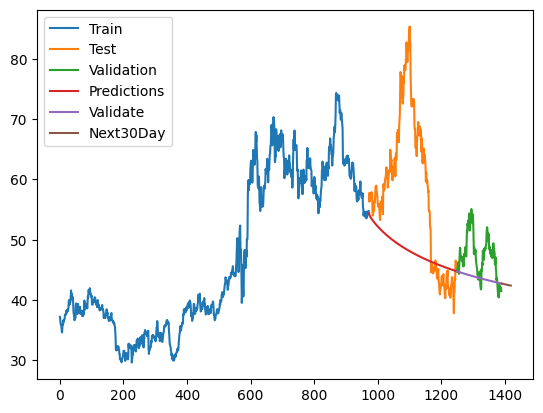

In [253]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(range(last_index+1, last_index+31),y_next_30_days)
plt.legend(['Train', 'Test', 'Validation', 'Predictions','Validate','Next30Day'])
plt.show()

## Recurrent Neural Network (RNN)

In [254]:
df1=df.reset_index()['Close']

In [255]:
#Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [256]:
# Split train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [257]:
# Function Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [258]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [259]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [260]:
from keras.layers import Dense, SimpleRNN

In [261]:
# 8. Define RNN Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [262]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 3s 111ms/step - loss: 0.0064 - val_loss: 0.0055
Epoch 2/100
14/14 [==============================] - 1s 66ms/step - loss: 0.0022 - val_loss: 0.0055
Epoch 3/100
14/14 [==============================] - 1s 66ms/step - loss: 0.0016 - val_loss: 0.0058
Epoch 4/100
14/14 [==============================] - 1s 61ms/step - loss: 0.0014 - val_loss: 0.0041
Epoch 5/100
14/14 [==============================] - 1s 64ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 6/100
14/14 [==============================] - 1s 51ms/step - loss: 9.5381e-04 - val_loss: 0.0027
Epoch 7/100
14/14 [==============================] - 1s 49ms/step - loss: 8.7466e-04 - val_loss: 0.0024
Epoch 8/100
14/14 [==============================] - 1s 48ms/step - loss: 8.1637e-04 - val_loss: 0.0024
Epoch 9/100
14/14 [==============================] - 1s 48ms/step - loss: 8.0363e-04 - val_loss: 0.0021
Epoch 10/100
14/14 [==============================] - 1s 50ms/step - loss: 7.5638e-

In [263]:
# Test, val
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 12ms/step


In [264]:
# Chuẩn hóa dữ liệu y_pred, y_pred_val
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [265]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

yval = scaler.inverse_transform(yval.reshape(-1,1))

In [266]:
# Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))

print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(ytest, y_pred)
valid_mae = mean_absolute_error(yval, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(ytest, y_pred)
valid_mape = mean_absolute_percentage_error(yval, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 1.5797717217982845
Validation RMSE: 0.9262879360868586
Testing MAE: 1.1621041081168435
Validation MAE: 0.6742772811498398
Testing MAPE: 0.020200405303161098
Validation MAPE: 0.014822371414707004


In [267]:
# Predict the next 7 days
x_input=val_data[40:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<7):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.20351979]
101
1 day input [0.40970981 0.42529561 0.43049089 0.42619133 0.45664638 0.43944826
 0.4249373  0.4145468  0.41795057 0.4405231  0.40899321 0.36277318
 0.32246504 0.34252959 0.33590109 0.32210681 0.32927266 0.33500537
 0.31189535 0.29917591 0.29111427 0.28341094 0.27893225 0.26209244
 0.26262986 0.2497313  0.24614834 0.25098532 0.2597635  0.25689715
 0.27051238 0.26191332 0.23109997 0.22500896 0.2174848  0.22500896
 0.27803653 0.27355785 0.29577214 0.28986025 0.33267643 0.32640631
 0.30455032 0.30526692 0.32586889 0.33948405 0.33339304 0.34145468
 0.33572197 0.34467934 0.34790399 0.35596563 0.38964527 0.40254389
 0.40218559 0.38498747 0.36402721 0.36026513 0.38373345 0.35686136
 0.33805091 0.34503764 0.33428876 0.32748121 0.32282335 0.32998927
 0.33321392 0.31440347 0.33446795 0.31888215 0.31046221 0.33070587
 0.32049448 0.35489072 0.34252959 0.33482625 0.3323182  0.32622719
 0.29165176 0.2927266  0.31332856 0.27803653 0.2714081  0.24489431
 0.25188105 0.24596922 0.23092085

In [268]:
scaler.inverse_transform(lst_output)

array([[40.96047469],
       [40.44006313],
       [40.58511191],
       [40.82989726],
       [40.04125656],
       [39.73194565],
       [39.68704851]])

In [269]:
# Predict the next 30 days
x_input=val_data[40:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.20351979]
101
1 day input [0.40970981 0.42529561 0.43049089 0.42619133 0.45664638 0.43944826
 0.4249373  0.4145468  0.41795057 0.4405231  0.40899321 0.36277318
 0.32246504 0.34252959 0.33590109 0.32210681 0.32927266 0.33500537
 0.31189535 0.29917591 0.29111427 0.28341094 0.27893225 0.26209244
 0.26262986 0.2497313  0.24614834 0.25098532 0.2597635  0.25689715
 0.27051238 0.26191332 0.23109997 0.22500896 0.2174848  0.22500896
 0.27803653 0.27355785 0.29577214 0.28986025 0.33267643 0.32640631
 0.30455032 0.30526692 0.32586889 0.33948405 0.33339304 0.34145468
 0.33572197 0.34467934 0.34790399 0.35596563 0.38964527 0.40254389
 0.40218559 0.38498747 0.36402721 0.36026513 0.38373345 0.35686136
 0.33805091 0.34503764 0.33428876 0.32748121 0.32282335 0.32998927
 0.33321392 0.31440347 0.33446795 0.31888215 0.31046221 0.33070587
 0.32049448 0.35489072 0.34252959 0.33482625 0.3323182  0.32622719
 0.29165176 0.2927266  0.31332856 0.27803653 0.2714081  0.24489431
 0.25188105 0.24596922 0.23092085

In [270]:
scaler.inverse_transform(lst_output)

array([[40.96047469],
       [40.44006313],
       [40.58511191],
       [40.82989726],
       [40.04125656],
       [39.73194565],
       [39.68704851],
       [39.62784055],
       [39.60105382],
       [39.21215794],
       [39.17391672],
       [39.15102606],
       [38.20336262],
       [37.61422918],
       [37.72455435],
       [37.59883537],
       [37.34268703],
       [37.04658484],
       [37.16264266],
       [37.27146896],
       [36.78908901],
       [36.53289367],
       [36.41709246],
       [36.10358313],
       [35.86538009],
       [35.51006743],
       [35.56477296],
       [35.18351783],
       [34.98091967],
       [34.8131    ]])

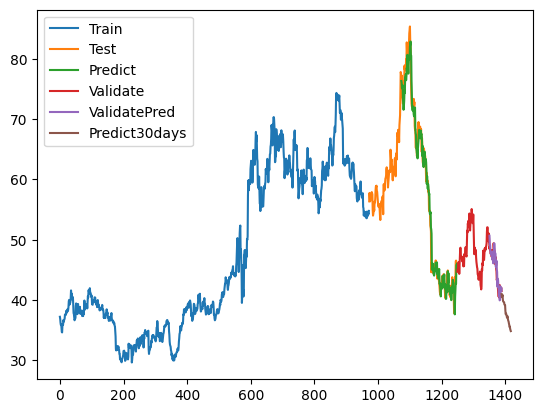

In [271]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

# 6:2:2

## Linear Regression

In [272]:
data = data[['Close']]
data = data.dropna() # Drop missing values
data = data.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [273]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

In [274]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [275]:
# Testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(x_test)

# Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(x_val)

In [276]:
# Predict for the next 7 days
last_index =  data.index[-1]
last_data1 = pd.RangeIndex(start=last_index, stop=last_index+7, step=1)

# Create an array of 7 consecutive integers starting from last_index
x_next_7_days = np.array(range(last_index+1, last_index+8)).reshape(-1, 1)

# Predict the closing prices for the next 7 days
y_next_7_days = model.predict(x_next_7_days)

# Print the predicted closing prices for the next 7 days
print('Predicted closing prices for the next 7 days:')
print(y_next_7_days)

Predicted closing prices for the next 7 days:
[82.99248585 83.0321239  83.07176196 83.11140001 83.15103807 83.19067612
 83.23031418]


In [277]:
# Predict for the next 30 days
last_index =  data.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(x_next_30_days)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[82.99248585 83.0321239  83.07176196 83.11140001 83.15103807 83.19067612
 83.23031418 83.26995224 83.30959029 83.34922835 83.3888664  83.42850446
 83.46814251 83.50778057 83.54741862 83.58705668 83.62669474 83.66633279
 83.70597085 83.7456089  83.78524696 83.82488501 83.86452307 83.90416112
 83.94379918 83.98343723 84.02307529 84.06271335 84.1023514  84.14198946]


In [278]:
# Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
valid_mae = mean_absolute_error(y_val, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 7.9245628349036
Validation RMSE: 29.775483547837148
Testing MAE: 6.872011336208827
Validation MAE: 27.894421794752965
Testing MAPE: 0.11118752643291303
Validation MAPE: 0.6056140158299554


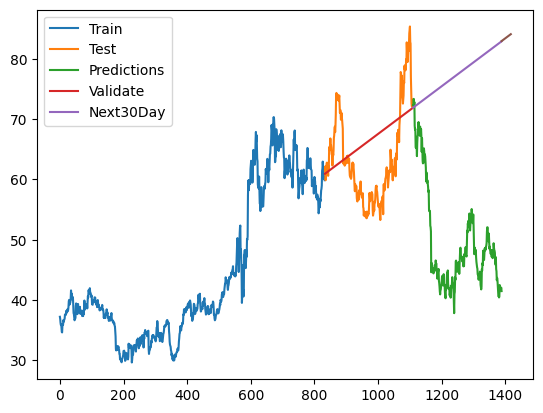

In [279]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

## Gated Recurrent Unit (GRU)

In [280]:
df = data

In [281]:
df1=df.reset_index()['Close']

In [282]:
#Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [283]:
#Split train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [284]:
#Function Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [285]:
#Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [286]:
#Reshape input to be [samples, time steps, features]
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [287]:
#Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [288]:
#Fit model with train data
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 5s 158ms/step - loss: 0.0507 - val_loss: 0.0098
Epoch 2/100
12/12 [==============================] - 1s 68ms/step - loss: 0.0158 - val_loss: 0.0094
Epoch 3/100
12/12 [==============================] - 1s 66ms/step - loss: 0.0058 - val_loss: 0.0113
Epoch 4/100
12/12 [==============================] - 1s 70ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 5/100
12/12 [==============================] - 1s 70ms/step - loss: 9.7166e-04 - val_loss: 0.0016
Epoch 6/100
12/12 [==============================] - 1s 65ms/step - loss: 8.9561e-04 - val_loss: 0.0015
Epoch 7/100
12/12 [==============================] - 1s 67ms/step - loss: 7.9738e-04 - val_loss: 0.0013
Epoch 8/100
12/12 [==============================] - 1s 68ms/step - loss: 7.6421e-04 - val_loss: 0.0012
Epoch 9/100
12/12 [==============================] - 1s 67ms/step - loss: 7.5273e-04 - val_loss: 0.0012
Epoch 10/100
12/12 [==============================] - 1s 69ms/step - loss: 7.31

In [289]:
#Test, val
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

6/6 [==============================] - 0s 13ms/step


In [290]:
#Normalization y_pred, y_pred_val
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [291]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

yval = scaler.inverse_transform(yval.reshape(-1,1))

In [292]:
#Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(ytest, y_pred)
valid_mae = mean_absolute_error(yval, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(ytest, y_pred)
valid_mape = mean_absolute_percentage_error(yval, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 1.367088661503996
Validation RMSE: 1.1454758267539669
Testing MAE: 1.0016922517256308
Validation MAE: 0.9006193782506364
Testing MAPE: 0.015577296620722185
Validation MAPE: 0.019615039714307544


In [293]:
#Predict 7 days after
x_input=val_data[179:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output1=[]
n_steps=100
i=0

while i < 7:
    if len(temp_input) >= n_steps:
        x_input = np.array(temp_input[:n_steps])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output1.extend(yhat.tolist())
        i += 1
    else:
        padding = n_steps - len(temp_input)
        x_input = np.array(temp_input + [0] * padding)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        lst_output1.extend(yhat.tolist())
        i += 1

0 day input [0.39286993 0.40970981 0.42529561 0.43049089 0.42619133 0.45664638
 0.43944826 0.4249373  0.4145468  0.41795057 0.4405231  0.40899321
 0.36277318 0.32246504 0.34252959 0.33590109 0.32210681 0.32927266
 0.33500537 0.31189535 0.29917591 0.29111427 0.28341094 0.27893225
 0.26209244 0.26262986 0.2497313  0.24614834 0.25098532 0.2597635
 0.25689715 0.27051238 0.26191332 0.23109997 0.22500896 0.2174848
 0.22500896 0.27803653 0.27355785 0.29577214 0.28986025 0.33267643
 0.32640631 0.30455032 0.30526692 0.32586889 0.33948405 0.33339304
 0.34145468 0.33572197 0.34467934 0.34790399 0.35596563 0.38964527
 0.40254389 0.40218559 0.38498747 0.36402721 0.36026513 0.38373345
 0.35686136 0.33805091 0.34503764 0.33428876 0.32748121 0.32282335
 0.32998927 0.33321392 0.31440347 0.33446795 0.31888215 0.31046221
 0.33070587 0.32049448 0.35489072 0.34252959 0.33482625 0.3323182
 0.32622719 0.29165176 0.2927266  0.31332856 0.27803653 0.2714081
 0.24489431 0.25188105 0.24596922 0.23092085 0.2187388

In [294]:
scaler.inverse_transform(lst_output1)

array([[41.8408444 ],
       [41.93691697],
       [42.0473403 ],
       [42.16276846],
       [42.28076766],
       [42.40041462],
       [42.52137247]])

In [295]:
#Predict 30 days after
x_input=val_data[179:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0

while i < 30:
    if len(temp_input) >= n_steps:
        x_input = np.array(temp_input[:n_steps])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        padding = n_steps - len(temp_input)
        x_input = np.array(temp_input + [0] * padding)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

0 day input [0.39286993 0.40970981 0.42529561 0.43049089 0.42619133 0.45664638
 0.43944826 0.4249373  0.4145468  0.41795057 0.4405231  0.40899321
 0.36277318 0.32246504 0.34252959 0.33590109 0.32210681 0.32927266
 0.33500537 0.31189535 0.29917591 0.29111427 0.28341094 0.27893225
 0.26209244 0.26262986 0.2497313  0.24614834 0.25098532 0.2597635
 0.25689715 0.27051238 0.26191332 0.23109997 0.22500896 0.2174848
 0.22500896 0.27803653 0.27355785 0.29577214 0.28986025 0.33267643
 0.32640631 0.30455032 0.30526692 0.32586889 0.33948405 0.33339304
 0.34145468 0.33572197 0.34467934 0.34790399 0.35596563 0.38964527
 0.40254389 0.40218559 0.38498747 0.36402721 0.36026513 0.38373345
 0.35686136 0.33805091 0.34503764 0.33428876 0.32748121 0.32282335
 0.32998927 0.33321392 0.31440347 0.33446795 0.31888215 0.31046221
 0.33070587 0.32049448 0.35489072 0.34252959 0.33482625 0.3323182
 0.32622719 0.29165176 0.2927266  0.31332856 0.27803653 0.2714081
 0.24489431 0.25188105 0.24596922 0.23092085 0.2187388

In [296]:
scaler.inverse_transform(lst_output)

array([[41.8408444 ],
       [41.93691697],
       [42.0473403 ],
       [42.16276846],
       [42.28076766],
       [42.40041462],
       [42.52137247],
       [42.64351562],
       [42.76679082],
       [42.89117811],
       [43.01666086],
       [43.14323741],
       [43.27090608],
       [43.39966938],
       [43.52952565],
       [43.66048319],
       [43.79254202],
       [43.92570545],
       [44.05997017],
       [44.19533949],
       [44.33181674],
       [44.46939362],
       [44.60807343],
       [44.7478512 ],
       [44.8887236 ],
       [45.03068729],
       [45.17374062],
       [45.31786862],
       [45.46307127],
       [45.60933861]])

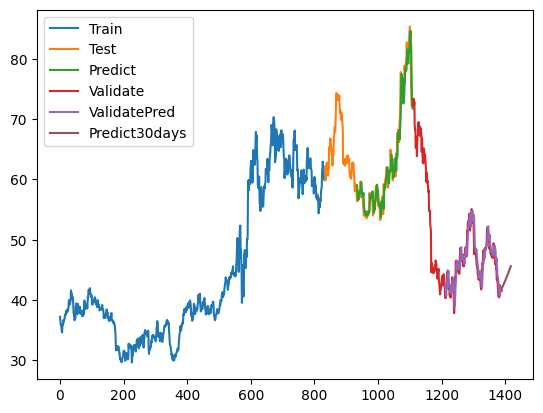

In [297]:
#Plot
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

## Autoregressive Integrated Moving Average (ARIMA)

In [298]:
data = data[['Close']]
data = data.dropna() # Drop missing values
data = data.reset_index(drop=True) # Reset the index

#Split the data into training, testing, and validation sets
train_size = int(0.6 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [299]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [300]:
#Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

#Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2401.758, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2403.710, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2403.708, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2400.350, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2398.292, Time=0.65 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2399.959, Time=1.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2403.828, Time=0.95 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2405.187, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2405.276, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2396.869, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2402.289, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2402.292, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2398.560, Time=0.76 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [301]:
#Testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

#Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [302]:
# Predict for the next 7 days
last_index =  data.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+7, step=1)

# Create an array of 7 consecutive integers starting from last_index
x_next_7_days = np.array(range(last_index+1, last_index+8)).reshape(-1, 1)

# Predict the closing prices for the next 7 days
y_next_7_days = model.predict(n_periods=len(x_next_7_days))

# Print the predicted closing prices for the next 7 days
print('Predicted closing prices for the next 7 days:')
print(y_next_7_days)

Predicted closing prices for the next 7 days:
[59.91352776 59.88236657 59.91132916 59.88441005 59.90942986 59.88617534
 59.90778912]


In [303]:
# Predict for the next 30 days
last_index =  data.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[59.91352776 59.88236657 59.91132916 59.88441005 59.90942986 59.88617534
 59.90778912 59.88770032 59.90637174 59.88901769 59.90514731 59.89015573
 59.90408956 59.89113884 59.90317582 59.89198812 59.90238646 59.89272178
 59.90170456 59.89335557 59.90111549 59.89390308 59.90060661 59.89437605
 59.90016701 59.89478464 59.89978725 59.8951376  59.89945919 59.89544251]


In [304]:
# Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
valid_mae = mean_absolute_error(y_val, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 8.579302167074664
Validation RMSE: 13.27986148123781
Testing MAE: 6.181375290740026
Validation MAE: 12.386766601652603
Testing MAPE: 0.08974797490343958
Validation MAPE: 0.2682333014847505


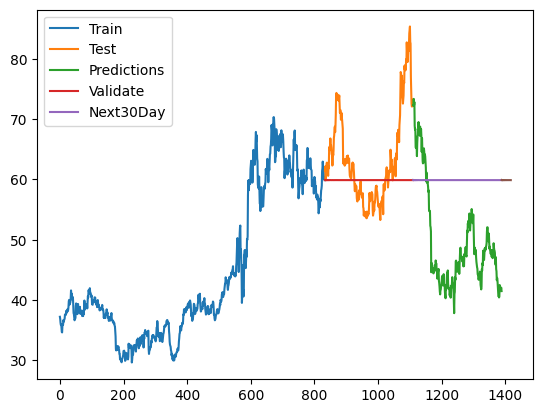

In [305]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

##Long short term memory (LSTM)

In [306]:
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Bidirectional

In [307]:
df1=df.reset_index()['Close']

In [308]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [309]:
#Split train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [310]:
#Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [311]:
#Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [312]:
#Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [313]:
#Define LSTM Model
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add a bidirectional LSTM layer
model.add(Bidirectional(LSTM(100, activation='relu')))

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [314]:
# Fit model with train data
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 7s 268ms/step - loss: 0.0557 - val_loss: 0.0402
Epoch 2/100
12/12 [==============================] - 5s 399ms/step - loss: 0.0160 - val_loss: 0.0354
Epoch 3/100
12/12 [==============================] - 4s 362ms/step - loss: 0.0090 - val_loss: 0.0174
Epoch 4/100
12/12 [==============================] - 3s 293ms/step - loss: 0.0064 - val_loss: 0.0114
Epoch 5/100
12/12 [==============================] - 4s 309ms/step - loss: 0.0048 - val_loss: 0.0087
Epoch 6/100
12/12 [==============================] - 5s 469ms/step - loss: 0.0037 - val_loss: 0.0058
Epoch 7/100
12/12 [==============================] - 4s 311ms/step - loss: 0.0028 - val_loss: 0.0044
Epoch 8/100
12/12 [==============================] - 4s 312ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 9/100
12/12 [==============================] - 4s 323ms/step - loss: 0.0023 - val_loss: 0.0038
Epoch 10/100
12/12 [==============================] - 5s 443ms/step - loss: 0.0021 - val_lo

In [315]:
#Test, val
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

6/6 [==============================] - 0s 21ms/step


In [316]:
#Normalization y_pred, y_pred_val
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [317]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [318]:
#Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(ytest, y_pred)
valid_mae = mean_absolute_error(yval, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(ytest, y_pred)
valid_mape = mean_absolute_percentage_error(yval, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 2.2913131187922287
Validation RMSE: 3.091065784065933
Testing MAE: 1.8701303655450987
Validation MAE: 2.826463849357005
Testing MAPE: 0.02924780919558761
Validation MAPE: 0.0622903771049089


In [319]:
val_data.shape

(279, 1)

In [320]:
#Predict the next 7 days
x_input=val_data[178:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<7):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.39286993 0.40970981 0.42529561 0.43049089 0.42619133 0.45664638
 0.43944826 0.4249373  0.4145468  0.41795057 0.4405231  0.40899321
 0.36277318 0.32246504 0.34252959 0.33590109 0.32210681 0.32927266
 0.33500537 0.31189535 0.29917591 0.29111427 0.28341094 0.27893225
 0.26209244 0.26262986 0.2497313  0.24614834 0.25098532 0.2597635
 0.25689715 0.27051238 0.26191332 0.23109997 0.22500896 0.2174848
 0.22500896 0.27803653 0.27355785 0.29577214 0.28986025 0.33267643
 0.32640631 0.30455032 0.30526692 0.32586889 0.33948405 0.33339304
 0.34145468 0.33572197 0.34467934 0.34790399 0.35596563 0.38964527
 0.40254389 0.40218559 0.38498747 0.36402721 0.36026513 0.38373345
 0.35686136 0.33805091 0.34503764 0.33428876 0.32748121 0.32282335
 0.32998927 0.33321392 0.31440347 0.33446795 0.31888215 0.31046221
 0.33070587 0.32049448 0.35489072 0.34252959 0.33482625 0.3323182
 0.32622719 0.29165176 0.2927266  0.31332856 0.27803653 0.2714081
 0.24489431 0.25188105 0.24596922 0.23092085 0.2187388

In [321]:
scaler.inverse_transform(lst_output)

array([[44.75249754],
       [46.04734212],
       [47.88553383],
       [48.99767899],
       [50.51069021],
       [51.64913966],
       [52.93107996]])

In [322]:
#Predict the next 30 days
x_input=val_data[178:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.39286993 0.40970981 0.42529561 0.43049089 0.42619133 0.45664638
 0.43944826 0.4249373  0.4145468  0.41795057 0.4405231  0.40899321
 0.36277318 0.32246504 0.34252959 0.33590109 0.32210681 0.32927266
 0.33500537 0.31189535 0.29917591 0.29111427 0.28341094 0.27893225
 0.26209244 0.26262986 0.2497313  0.24614834 0.25098532 0.2597635
 0.25689715 0.27051238 0.26191332 0.23109997 0.22500896 0.2174848
 0.22500896 0.27803653 0.27355785 0.29577214 0.28986025 0.33267643
 0.32640631 0.30455032 0.30526692 0.32586889 0.33948405 0.33339304
 0.34145468 0.33572197 0.34467934 0.34790399 0.35596563 0.38964527
 0.40254389 0.40218559 0.38498747 0.36402721 0.36026513 0.38373345
 0.35686136 0.33805091 0.34503764 0.33428876 0.32748121 0.32282335
 0.32998927 0.33321392 0.31440347 0.33446795 0.31888215 0.31046221
 0.33070587 0.32049448 0.35489072 0.34252959 0.33482625 0.3323182
 0.32622719 0.29165176 0.2927266  0.31332856 0.27803653 0.2714081
 0.24489431 0.25188105 0.24596922 0.23092085 0.2187388

In [323]:
scaler.inverse_transform(lst_output)

array([[44.75249754],
       [46.04734212],
       [47.88553383],
       [48.99767899],
       [50.51069021],
       [51.64913966],
       [52.93107996],
       [54.19864373],
       [55.39532629],
       [56.57291279],
       [57.75859586],
       [58.87915034],
       [60.0210284 ],
       [61.11803677],
       [62.17592473],
       [63.15352569],
       [64.05844215],
       [64.88574329],
       [65.63461729],
       [66.30258877],
       [66.84861757],
       [67.27626039],
       [67.5410102 ],
       [67.73468916],
       [67.81551183],
       [67.84482053],
       [67.80694779],
       [67.76129623],
       [67.57267451],
       [67.39223088]])

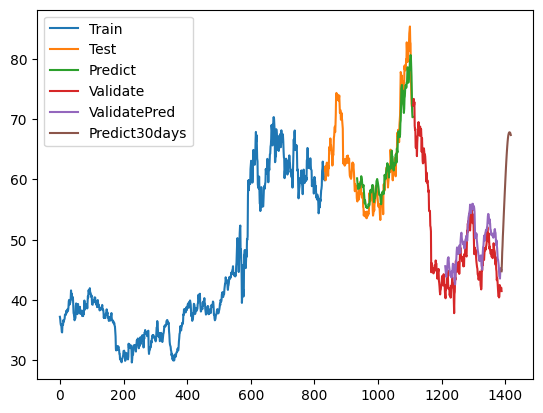

In [324]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

## Exponential Smoothing (ETS)

In [325]:
# 4. Split train test
data = data[['Close']]
data = data.dropna() # Drop missing values
data = data.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [326]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

In [327]:
pip install sktime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [328]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

In [329]:
simple_exp = ExponentialSmoothing(trend=None, seasonal=None)

In [330]:
#5. Fit model with train data
simple_exp.fit(y_train)

ExponentialSmoothing()

In [331]:
# 6. Testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])

# 7. Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])

In [332]:
y_pred = simple_exp.predict(test_data.index)

In [333]:
y_pred_val= simple_exp.predict(val_data.index)

In [334]:
#8. Predict next 7 days
last_index =  data.index[-1]
fh = list(range(last_index,last_index+7))
y_next_7_days = simple_exp.predict(fh)
y_next_7_days

array([[59.88000108],
       [59.88000108],
       [59.88000108],
       [59.88000108],
       [59.88000108],
       [59.88000108],
       [59.88000108]])

In [335]:
#9. Predict next 30 days
last_index =  data.index[-1]
fh = list(range(last_index,last_index+30))
y_next_30_days = simple_exp.predict(fh)
y_next_30_days

array([[59.88000108],
       [59.88000108],
       [59.88000108],
       [59.88000108],
       [59.88000108],
       [59.88000108],
       [59.88000108],
       [59.88000108],
       [59.88000108],
       [59.88000108],
       [59.88000108],
       [59.88000108],
       [59.88000108],
       [59.88000108],
       [59.88000108],
       [59.88000108],
       [59.88000108],
       [59.88000108],
       [59.88000108],
       [59.88000108],
       [59.88000108],
       [59.88000108],
       [59.88000108],
       [59.88000108],
       [59.88000108],
       [59.88000108],
       [59.88000108],
       [59.88000108],
       [59.88000108],
       [59.88000108]])

In [336]:
# 10. Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))

print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
valid_mae = mean_absolute_error(y_val, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 8.587008021491435
Validation RMSE: 13.266388964093032
Testing MAE: 6.185884026210904
Validation MAE: 12.37466019624632
Testing MAPE: 0.08979722865102265
Validation MAPE: 0.2679532640446096


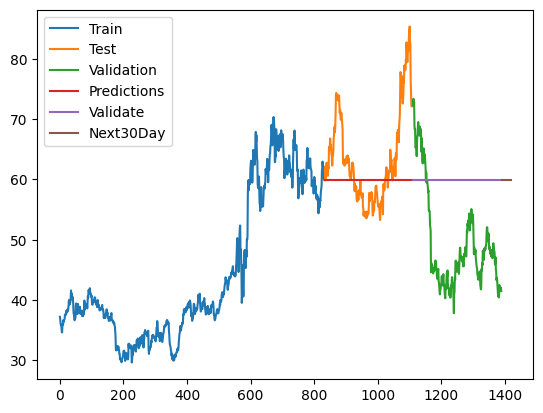

In [337]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(range(last_index+1, last_index+31),y_next_30_days)
plt.legend(['Train', 'Test', 'Validation', 'Predictions','Validate','Next30Day'])
plt.show()

## Random Forest

In [338]:
from sklearn.ensemble import RandomForestRegressor

In [339]:
data = data[['Close']]
data = data.dropna() # Drop missing values
data = data.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [340]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

In [341]:
# Testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])

# Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])

In [342]:
model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
model.fit(x_train, y_train)

RandomForestRegressor(max_depth=5, random_state=42)

In [343]:
y_pred = model.predict(x_test)

In [344]:
y_pred_val =  model.predict(x_val)

In [345]:
last_index =  data.index[-1]
# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(x_next_30_days)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[60.59174199 60.59174199 60.59174199 60.59174199 60.59174199 60.59174199
 60.59174199 60.59174199 60.59174199 60.59174199 60.59174199 60.59174199
 60.59174199 60.59174199 60.59174199 60.59174199 60.59174199 60.59174199
 60.59174199 60.59174199 60.59174199 60.59174199 60.59174199 60.59174199
 60.59174199 60.59174199 60.59174199 60.59174199 60.59174199 60.59174199]


In [346]:
# Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))

print('Testing RMSE:', test_rmse.item())
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
valid_mae = mean_absolute_error(y_val, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 8.295021510545377
Validation RMSE: 13.826732300612123
Testing MAE: 6.020919111445617
Validation MAE: 12.872113522844572
Testing MAPE: 0.08810715627455375
Validation MAPE: 0.27944569248732165


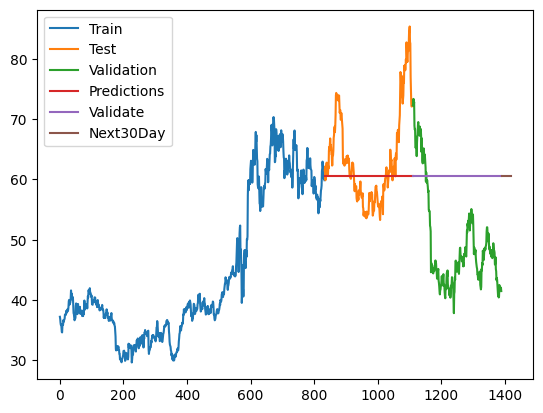

In [347]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(range(last_index+1, last_index+31),y_next_30_days)
plt.legend(['Train', 'Test', 'Validation', 'Predictions','Validate','Next30Day'])
plt.show()

## Bayesian Neural Networks (BNN)

In [348]:
# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [349]:
train_dates = train_data.index.values
test_dates = test_data.index.values
val_dates = val_data.index.values
train_close_prices = train_data['Close'].values
val_close_prices = val_data['Close'].values
test_close_prices = test_data['Close'].values

In [350]:
import torch
import torch.nn as nn

In [351]:
X_train = torch.from_numpy(train_dates.reshape(-1, 1)).float()
y_train = torch.from_numpy(train_close_prices.reshape(-1, 1)).float()
X_test = torch.from_numpy(test_dates.reshape(-1, 1)).float()
y_test = torch.from_numpy(test_close_prices.reshape(-1, 1)).float()
X_val = torch.from_numpy(val_dates.reshape(-1, 1)).float()
y_val = torch.from_numpy(val_close_prices.reshape(-1, 1)).float()

In [352]:
# Determining the architecture of a Bayesian Neural Network.
class BNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(BNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [353]:
# Determining the loss function and optimization algorithm.
criterion = nn.MSELoss()
learning_rate = 0.001
num_epochs = 1000

In [354]:
# Built model BNN
model = BNN(input_size=1, output_size=1)

In [355]:
# Train model BNN
for epoch in range(num_epochs):
    model.train()

    # Tính đầu ra dự đoán của mô hình
    y_pred = model(X_train)

    # Tính lỗi dự đoán so với giá thực tế
    loss = criterion(y_pred, y_train)

    # Backpropagation và cập nhật trọng số
    loss.backward()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

Epoch [100/1000], Loss: 698.0062255859375
Epoch [200/1000], Loss: 2018.7327880859375
Epoch [300/1000], Loss: 688.6062622070312
Epoch [400/1000], Loss: 632.9036865234375
Epoch [500/1000], Loss: 247.79212951660156
Epoch [600/1000], Loss: 1163.1663818359375
Epoch [700/1000], Loss: 350.23095703125
Epoch [800/1000], Loss: 485.8650817871094
Epoch [900/1000], Loss: 919.1694946289062
Epoch [1000/1000], Loss: 778.5618286132812


In [356]:
# Test
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test)

In [357]:
# Validation
model.eval()
with torch.no_grad():
    y_pred_val = model(X_val)

In [358]:
y_test = np.array(test_data['Close'])
y_val = np.array(val_data['Close'])

In [359]:
# Evaluating algorithm accuracy using
#RMSE
test_rmse = torch.sqrt(torch.mean((y_pred_test - y_test)**2))
valid_rmse = torch.sqrt(torch.mean((y_pred_val - y_val)**2))
#test_rmse = np.sqrt(np.mean((y_pred_test - y_test)**2))
#valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))

print('Testing RMSE:', test_rmse.item())
print('Validation RMSE:', valid_rmse.item())

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred_test)
valid_mae = mean_absolute_error(y_val, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred_test)
valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 70.89364790350065
Validation RMSE: 122.30877134401743
Testing MAE: 69.63276910609717
Validation MAE: 121.53177910808166
Testing MAPE: 1.1169857487103676
Validation MAPE: 2.5525752406178666


In [360]:
# Predict the next 7 days
last_index =  data.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+7, step=1)

x_next_7_days = torch.from_numpy(np.array(range(last_index+1, last_index+8)).reshape(-1, 1)).float()

model.eval()
with torch.no_grad():
    y_pred_next = model(x_next_7_days)

# Chuyển đổi kết quả dự đoán thành mảng numpy
y_pred_next = y_pred_next.numpy().flatten()

# Hiển thị kết quả dự đoán
for i in range(len(x_next_7_days)):
    print(f'{y_pred_next[i]}')

190.1240692138672
190.25994873046875
190.3957977294922
190.5316619873047
190.66754150390625
190.8034210205078
190.9392852783203


In [361]:
# Predict the next 30 days
last_index =  data.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = torch.from_numpy(np.array(range(last_index+1, last_index+31)).reshape(-1, 1)).float()

model.eval()
with torch.no_grad():
    y_pred_next = model(x_next_30_days)

# Chuyển đổi kết quả dự đoán thành mảng numpy
y_pred_next = y_pred_next.numpy().flatten()

# Hiển thị kết quả dự đoán
for i in range(len(x_next_30_days)):
    print(f'{y_pred_next[i]}')

190.1240692138672
190.25994873046875
190.3957977294922
190.5316619873047
190.66754150390625
190.8034210205078
190.9392852783203
191.07513427734375
191.2110137939453
191.3468780517578
191.4827423095703
191.61862182617188
191.75448608398438
191.89035034179688
192.02622985839844
192.16207885742188
192.2979278564453
192.43380737304688
192.56968688964844
192.70555114746094
192.8414306640625
192.977294921875
193.11314392089844
193.2490234375
193.38490295410156
193.52076721191406
193.65663146972656
193.79249572753906
193.92835998535156
194.06422424316406


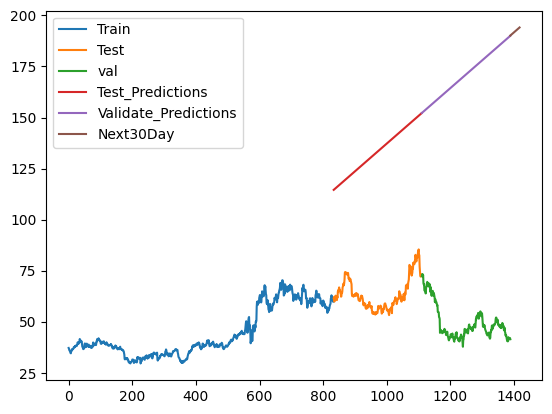

In [362]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred_test)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data, y_pred_next)
plt.legend(['Train', 'Test','val', 'Test_Predictions','Validate_Predictions','Next30Day'])
plt.show()

## Gaussian Process Regression (GPR)

In [363]:
# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [364]:
# Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

In [365]:
# Testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])

# Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])

In [366]:
# Choose best kernel
kernels = [RBF(), Matern(), RationalQuadratic(), ExpSineSquared(), DotProduct()]
param_grid = {'kernel': kernels}

gpr = GaussianProcessRegressor()
grid_search = GridSearchCV(gpr, param_grid, cv=KFold(n_splits=5))

grid_search.fit(x_train, y_train)


print("Best Kernel:", grid_search.best_estimator_.kernel)
print("Best Score:", grid_search.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter periodicity is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
---------------------------------------------

Best Kernel: RationalQuadratic(alpha=1, length_scale=1)
Best Score: -6.544519658036842


In [367]:
# Built model GPR
kernel = RationalQuadratic(alpha=1, length_scale=1)
gpr = GaussianProcessRegressor(kernel=kernel, random_state=42)

In [368]:
gpr.fit(x_train, y_train)

GaussianProcessRegressor(kernel=RationalQuadratic(alpha=1, length_scale=1),
                         random_state=42)

In [369]:
y_pred = gpr.predict(x_test)

In [370]:
y_pred_val =  gpr.predict(x_val)

In [371]:
# 12. Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))

print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
valid_mae = mean_absolute_error(y_val, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 18.468240474464842
Validation RMSE: 11.494386157078782
Testing MAE: 16.209873426783513
Validation MAE: 8.549971484004189
Testing MAPE: 0.24397980734750313
Validation MAPE: 0.1542362438910983


In [372]:
# Predict the next 7 days
last_index =  data.index[-1]
# Create an array of 7 consecutive integers starting from last_index
x_next_7_days = np.array(range(last_index+1, last_index+8)).reshape(-1, 1)

# Predict the closing prices for the next 7 days
y_next_7_days = gpr.predict(x_next_7_days)

# Print the predicted closing prices for the next 7 days
print('Predicted closing prices for the next 7 days:')
print(y_next_7_days)

Predicted closing prices for the next 7 days:
[39.48372361 39.47442782 39.46514953 39.45588869 39.44664522 39.43741908
 39.42821019]


In [373]:
# Predict the next 30 days
last_index =  data.index[-1]
# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = gpr.predict(x_next_30_days)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[39.48372361 39.47442782 39.46514953 39.45588869 39.44664522 39.43741908
 39.42821019 39.41901851 39.40984397 39.40068652 39.39154609 39.38242263
 39.37331608 39.36422638 39.35515348 39.34609731 39.33705783 39.32803497
 39.31902868 39.31003891 39.30106559 39.29210867 39.2831681  39.27424382
 39.26533578 39.25644393 39.2475682  39.23870855 39.22986492 39.22103726]


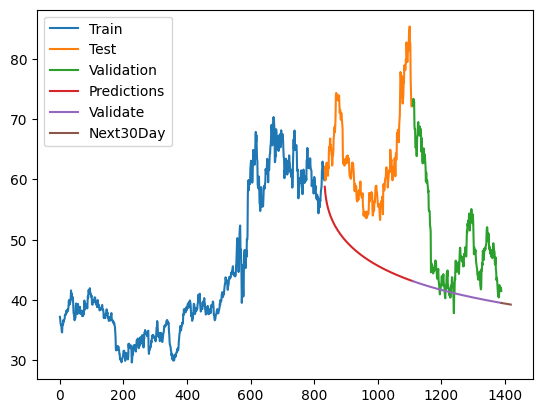

In [374]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(range(last_index+1, last_index+31),y_next_30_days)
plt.legend(['Train', 'Test', 'Validation', 'Predictions','Validate','Next30Day'])
plt.show()

## Recurrent Neural Network (RNN)

In [375]:
df1=df.reset_index()['Close']

In [376]:
#Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [377]:
# Split train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [378]:
# Function Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [379]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [380]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [381]:
from keras.layers import Dense, SimpleRNN

In [382]:
# 8. Define RNN Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [383]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 5s 89ms/step - loss: 0.0111 - val_loss: 0.0132
Epoch 2/100
12/12 [==============================] - 1s 48ms/step - loss: 0.0023 - val_loss: 0.0063
Epoch 3/100
12/12 [==============================] - 1s 49ms/step - loss: 0.0013 - val_loss: 0.0042
Epoch 4/100
12/12 [==============================] - 1s 48ms/step - loss: 0.0012 - val_loss: 0.0043
Epoch 5/100
12/12 [==============================] - 1s 50ms/step - loss: 0.0010 - val_loss: 0.0032
Epoch 6/100
12/12 [==============================] - 1s 51ms/step - loss: 9.2770e-04 - val_loss: 0.0027
Epoch 7/100
12/12 [==============================] - 1s 47ms/step - loss: 9.0393e-04 - val_loss: 0.0027
Epoch 8/100
12/12 [==============================] - 1s 50ms/step - loss: 9.7743e-04 - val_loss: 0.0024
Epoch 9/100
12/12 [==============================] - 1s 46ms/step - loss: 8.2872e-04 - val_loss: 0.0024
Epoch 10/100
12/12 [==============================] - 1s 51ms/step - loss: 8.1997e-0

In [384]:
# Test, val
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

6/6 [==============================] - 0s 8ms/step


In [385]:
# Chuẩn hóa dữ liệu y_pred, y_pred_val
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [386]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

yval = scaler.inverse_transform(yval.reshape(-1,1))

In [387]:
# Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))

print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(ytest, y_pred)
valid_mae = mean_absolute_error(yval, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(ytest, y_pred)
valid_mape = mean_absolute_percentage_error(yval, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 1.613679312640734
Validation RMSE: 1.197098261004851
Testing MAE: 1.2081988508051091
Validation MAE: 0.9602225014332975
Testing MAPE: 0.01849754615392775
Validation MAPE: 0.02088973474968301


In [388]:
# Predict the next 7 days
x_input=val_data[178:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<7):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.39286993 0.40970981 0.42529561 0.43049089 0.42619133 0.45664638
 0.43944826 0.4249373  0.4145468  0.41795057 0.4405231  0.40899321
 0.36277318 0.32246504 0.34252959 0.33590109 0.32210681 0.32927266
 0.33500537 0.31189535 0.29917591 0.29111427 0.28341094 0.27893225
 0.26209244 0.26262986 0.2497313  0.24614834 0.25098532 0.2597635
 0.25689715 0.27051238 0.26191332 0.23109997 0.22500896 0.2174848
 0.22500896 0.27803653 0.27355785 0.29577214 0.28986025 0.33267643
 0.32640631 0.30455032 0.30526692 0.32586889 0.33948405 0.33339304
 0.34145468 0.33572197 0.34467934 0.34790399 0.35596563 0.38964527
 0.40254389 0.40218559 0.38498747 0.36402721 0.36026513 0.38373345
 0.35686136 0.33805091 0.34503764 0.33428876 0.32748121 0.32282335
 0.32998927 0.33321392 0.31440347 0.33446795 0.31888215 0.31046221
 0.33070587 0.32049448 0.35489072 0.34252959 0.33482625 0.3323182
 0.32622719 0.29165176 0.2927266  0.31332856 0.27803653 0.2714081
 0.24489431 0.25188105 0.24596922 0.23092085 0.2187388

In [389]:
scaler.inverse_transform(lst_output)

array([[41.27072301],
       [41.05334739],
       [41.59335076],
       [41.33780712],
       [41.13324346],
       [41.45729438],
       [41.58513274]])

In [390]:
# Predict the next 30 days
x_input=val_data[178:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.39286993 0.40970981 0.42529561 0.43049089 0.42619133 0.45664638
 0.43944826 0.4249373  0.4145468  0.41795057 0.4405231  0.40899321
 0.36277318 0.32246504 0.34252959 0.33590109 0.32210681 0.32927266
 0.33500537 0.31189535 0.29917591 0.29111427 0.28341094 0.27893225
 0.26209244 0.26262986 0.2497313  0.24614834 0.25098532 0.2597635
 0.25689715 0.27051238 0.26191332 0.23109997 0.22500896 0.2174848
 0.22500896 0.27803653 0.27355785 0.29577214 0.28986025 0.33267643
 0.32640631 0.30455032 0.30526692 0.32586889 0.33948405 0.33339304
 0.34145468 0.33572197 0.34467934 0.34790399 0.35596563 0.38964527
 0.40254389 0.40218559 0.38498747 0.36402721 0.36026513 0.38373345
 0.35686136 0.33805091 0.34503764 0.33428876 0.32748121 0.32282335
 0.32998927 0.33321392 0.31440347 0.33446795 0.31888215 0.31046221
 0.33070587 0.32049448 0.35489072 0.34252959 0.33482625 0.3323182
 0.32622719 0.29165176 0.2927266  0.31332856 0.27803653 0.2714081
 0.24489431 0.25188105 0.24596922 0.23092085 0.2187388

In [391]:
scaler.inverse_transform(lst_output)

array([[41.27072301],
       [41.05334739],
       [41.59335076],
       [41.33780712],
       [41.13324346],
       [41.45729438],
       [41.58513274],
       [41.66480506],
       [42.0179218 ],
       [42.27983273],
       [42.5312998 ],
       [42.57993664],
       [42.63529344],
       [42.46757859],
       [42.78601748],
       [42.98428288],
       [43.32968817],
       [43.9505375 ],
       [44.37235451],
       [44.48769284],
       [44.84374578],
       [44.92357363],
       [45.09175845],
       [45.54173796],
       [45.76532118],
       [46.18841414],
       [46.7915465 ],
       [47.21406886],
       [47.85878702],
       [48.42012894]])

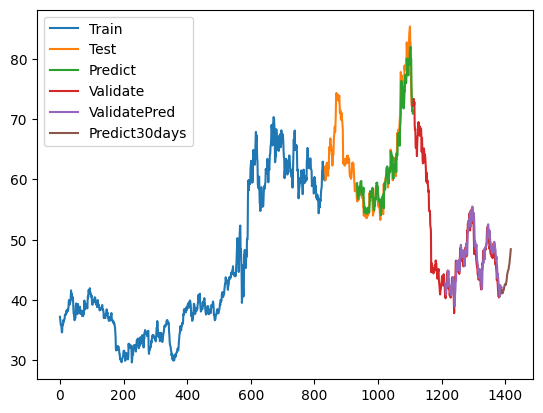

In [392]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

# 8:1:1

## Linear Regression

In [393]:
data = data[['Close']]
data = data.dropna() # Drop missing values
data = data.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.8 * len(data))
test_size = int(0.1 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [394]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

In [395]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [396]:
# Testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(x_test)

# Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(x_val)

In [397]:
# Predict for the next 7 days
last_index =  data.index[-1]
last_data1 = pd.RangeIndex(start=last_index, stop=last_index+7, step=1)

# Create an array of 7 consecutive integers starting from last_index
x_next_7_days = np.array(range(last_index+1, last_index+8)).reshape(-1, 1)

# Predict the closing prices for the next 7 days
y_next_7_days = model.predict(x_next_7_days)

# Print the predicted closing prices for the next 7 days
print('Predicted closing prices for the next 7 days:')
print(y_next_7_days)

Predicted closing prices for the next 7 days:
[79.86350241 79.90020293 79.93690346 79.97360398 80.0103045  80.04700503
 80.08370555]


In [398]:
# Predict for the next 30 days
last_index =  data.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(x_next_30_days)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[79.86350241 79.90020293 79.93690346 79.97360398 80.0103045  80.04700503
 80.08370555 80.12040608 80.1571066  80.19380712 80.23050765 80.26720817
 80.30390869 80.34060922 80.37730974 80.41401027 80.45071079 80.48741131
 80.52411184 80.56081236 80.59751289 80.63421341 80.67091393 80.70761446
 80.74431498 80.78101551 80.81771603 80.85441655 80.89111708 80.9278176 ]


In [399]:
# Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
valid_mae = mean_absolute_error(y_val, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 23.812337775274653
Validation RMSE: 30.221698745097477
Testing MAE: 20.68273945910554
Validation MAE: 29.932472635885485
Testing MAPE: 0.46127455711375376
Validation MAPE: 0.6415897855836397


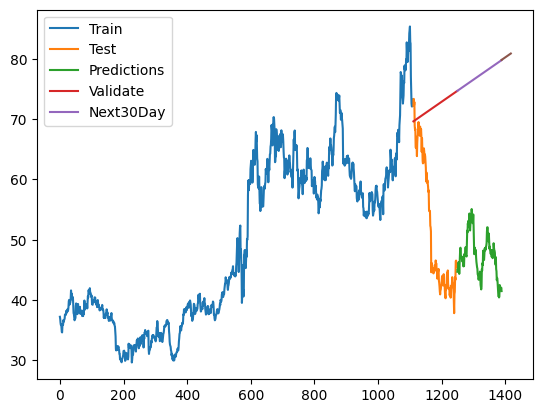

In [400]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

## Gated Recurrent Unit (GRU)

In [401]:
df = data

In [402]:
df1=df.reset_index()['Close']

In [403]:
#Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [404]:
#Split train test
train_size = int(0.8 * len(df1))
test_size = int(0.1 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [405]:
#Function Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [406]:
#Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [407]:
#Reshape input to be [samples, time steps, features]
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [408]:
#Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [409]:
#Fit model with train data
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
16/16 [==============================] - 4s 98ms/step - loss: 0.0625 - val_loss: 0.0245
Epoch 2/100
16/16 [==============================] - 1s 64ms/step - loss: 0.0118 - val_loss: 0.0015
Epoch 3/100
16/16 [==============================] - 1s 66ms/step - loss: 0.0046 - val_loss: 0.0025
Epoch 4/100
16/16 [==============================] - 1s 65ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 5/100
16/16 [==============================] - 1s 65ms/step - loss: 9.7676e-04 - val_loss: 0.0011
Epoch 6/100
16/16 [==============================] - 1s 66ms/step - loss: 9.1888e-04 - val_loss: 0.0011
Epoch 7/100
16/16 [==============================] - 1s 83ms/step - loss: 8.8503e-04 - val_loss: 0.0011
Epoch 8/100
16/16 [==============================] - 2s 111ms/step - loss: 8.4576e-04 - val_loss: 0.0010
Epoch 9/100
16/16 [==============================] - 2s 112ms/step - loss: 8.1799e-04 - val_loss: 0.0010
Epoch 10/100
16/16 [==============================] - 1s 66ms/step - loss: 8.0

In [410]:
#Test, val
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 13ms/step


In [411]:
#Normalization y_pred, y_pred_val
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [412]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

yval = scaler.inverse_transform(yval.reshape(-1,1))

In [413]:
#Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(ytest, y_pred)
valid_mae = mean_absolute_error(yval, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(ytest, y_pred)
valid_mape = mean_absolute_percentage_error(yval, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 1.3126689259700046
Validation RMSE: 0.9869609718366741
Testing MAE: 1.0374845556310706
Validation MAE: 0.8058832608736478
Testing MAPE: 0.0245889246227718
Validation MAPE: 0.017761598926045705


In [414]:
#Predict 7 days after
x_input=val_data[40:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output1=[]
n_steps=100
i=0

while i < 7:
    if len(temp_input) >= n_steps:
        x_input = np.array(temp_input[:n_steps])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output1.extend(yhat.tolist())
        i += 1
    else:
        padding = n_steps - len(temp_input)
        x_input = np.array(temp_input + [0] * padding)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        lst_output1.extend(yhat.tolist())
        i += 1

0 day input [0.39286993 0.40970981 0.42529561 0.43049089 0.42619133 0.45664638
 0.43944826 0.4249373  0.4145468  0.41795057 0.4405231  0.40899321
 0.36277318 0.32246504 0.34252959 0.33590109 0.32210681 0.32927266
 0.33500537 0.31189535 0.29917591 0.29111427 0.28341094 0.27893225
 0.26209244 0.26262986 0.2497313  0.24614834 0.25098532 0.2597635
 0.25689715 0.27051238 0.26191332 0.23109997 0.22500896 0.2174848
 0.22500896 0.27803653 0.27355785 0.29577214 0.28986025 0.33267643
 0.32640631 0.30455032 0.30526692 0.32586889 0.33948405 0.33339304
 0.34145468 0.33572197 0.34467934 0.34790399 0.35596563 0.38964527
 0.40254389 0.40218559 0.38498747 0.36402721 0.36026513 0.38373345
 0.35686136 0.33805091 0.34503764 0.33428876 0.32748121 0.32282335
 0.32998927 0.33321392 0.31440347 0.33446795 0.31888215 0.31046221
 0.33070587 0.32049448 0.35489072 0.34252959 0.33482625 0.3323182
 0.32622719 0.29165176 0.2927266  0.31332856 0.27803653 0.2714081
 0.24489431 0.25188105 0.24596922 0.23092085 0.2187388

In [415]:
scaler.inverse_transform(lst_output1)

array([[41.84187248],
       [41.93775707],
       [42.06166443],
       [42.19041442],
       [42.32073316],
       [42.45202342],
       [42.5841388 ]])

In [416]:
#Predict 30 days after
x_input=val_data[40:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0

while i < 30:
    if len(temp_input) >= n_steps:
        x_input = np.array(temp_input[:n_steps])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        padding = n_steps - len(temp_input)
        x_input = np.array(temp_input + [0] * padding)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

0 day input [0.39286993 0.40970981 0.42529561 0.43049089 0.42619133 0.45664638
 0.43944826 0.4249373  0.4145468  0.41795057 0.4405231  0.40899321
 0.36277318 0.32246504 0.34252959 0.33590109 0.32210681 0.32927266
 0.33500537 0.31189535 0.29917591 0.29111427 0.28341094 0.27893225
 0.26209244 0.26262986 0.2497313  0.24614834 0.25098532 0.2597635
 0.25689715 0.27051238 0.26191332 0.23109997 0.22500896 0.2174848
 0.22500896 0.27803653 0.27355785 0.29577214 0.28986025 0.33267643
 0.32640631 0.30455032 0.30526692 0.32586889 0.33948405 0.33339304
 0.34145468 0.33572197 0.34467934 0.34790399 0.35596563 0.38964527
 0.40254389 0.40218559 0.38498747 0.36402721 0.36026513 0.38373345
 0.35686136 0.33805091 0.34503764 0.33428876 0.32748121 0.32282335
 0.32998927 0.33321392 0.31440347 0.33446795 0.31888215 0.31046221
 0.33070587 0.32049448 0.35489072 0.34252959 0.33482625 0.3323182
 0.32622719 0.29165176 0.2927266  0.31332856 0.27803653 0.2714081
 0.24489431 0.25188105 0.24596922 0.23092085 0.2187388

In [417]:
scaler.inverse_transform(lst_output)

array([[41.84187248],
       [41.93775707],
       [42.06166443],
       [42.19041442],
       [42.32073316],
       [42.45202342],
       [42.5841388 ],
       [42.7170344 ],
       [42.85072103],
       [42.98519701],
       [43.12047317],
       [43.25656199],
       [43.39346595],
       [43.53119088],
       [43.66973595],
       [43.80910781],
       [43.9492998 ],
       [44.0903136 ],
       [44.23214754],
       [44.37478831],
       [44.51823424],
       [44.66247868],
       [44.80751165],
       [44.95332318],
       [45.09991325],
       [45.24725691],
       [45.39534586],
       [45.54418174],
       [45.69373296],
       [45.84399452]])

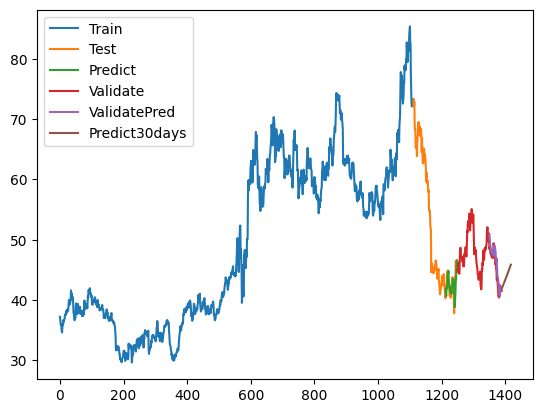

In [418]:
#Plot
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

## Autoregressive Integrated Moving Average (ARIMA)

In [419]:
data = data[['Close']]
data = data.dropna() # Drop missing values
data = data.reset_index(drop=True) # Reset the index

#Split the data into training, testing, and validation sets
train_size = int(0.8 * len(data))
test_size = int(0.1 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [420]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [421]:
#Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

#Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3321.294, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3322.435, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3322.423, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3320.249, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3318.117, Time=1.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3320.016, Time=1.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3326.369, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3324.366, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3324.381, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3317.056, Time=0.87 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3321.326, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3321.337, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3325.292, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [422]:
#Testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

#Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [423]:
# Predict for the next 7 days
last_index =  data.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+7, step=1)

# Create an array of 7 consecutive integers starting from last_index
x_next_7_days = np.array(range(last_index+1, last_index+8)).reshape(-1, 1)

# Predict the closing prices for the next 7 days
y_next_7_days = model.predict(n_periods=len(x_next_7_days))

# Print the predicted closing prices for the next 7 days
print('Predicted closing prices for the next 7 days:')
print(y_next_7_days)

Predicted closing prices for the next 7 days:
[72.39592524 72.31425919 72.39187497 72.31810859 72.38821648 72.32158563
 72.38491189]


In [424]:
# Predict for the next 30 days
last_index =  data.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[72.39592524 72.31425919 72.39187497 72.31810859 72.38821648 72.32158563
 72.38491189 72.32472633 72.38192695 72.32756323 72.37923075 72.33012571
 72.37679536 72.33244031 72.37459555 72.33453103 72.37260853 72.3364195
 72.37081371 72.3381253  72.36919251 72.3396661  72.36772813 72.34105785
 72.3664054  72.34231497 72.36521063 72.3434505  72.36413142 72.34447618]


In [425]:
# Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
valid_mae = mean_absolute_error(y_val, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 23.32367138804043
Validation RMSE: 25.24217691369106
Testing MAE: 20.712218723924018
Validation MAE: 25.010564284398072
Testing MAPE: 0.4578062576097855
Validation MAPE: 0.5362454507534103


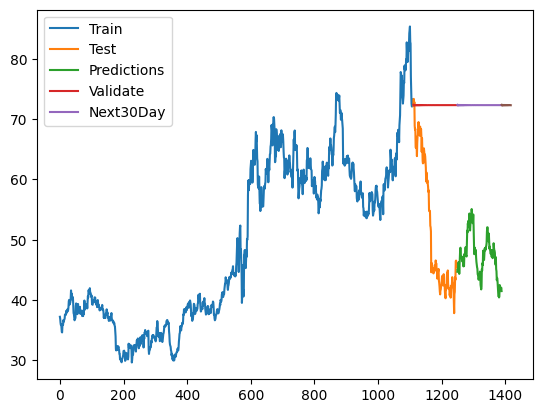

In [426]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

##Long short term memory (LSTM)

In [427]:
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Bidirectional

In [428]:
df1=df.reset_index()['Close']

In [429]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [430]:
#Split train test
train_size = int(0.8 * len(df1))
test_size = int(0.1 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [431]:
#Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [432]:
#Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [433]:
#Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [434]:
#Define LSTM Model
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add a bidirectional LSTM layer
model.add(Bidirectional(LSTM(100, activation='relu')))

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [435]:
# Fit model with train data
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
16/16 [==============================] - 8s 256ms/step - loss: 0.0693 - val_loss: 0.0288
Epoch 2/100
16/16 [==============================] - 6s 386ms/step - loss: 0.0118 - val_loss: 0.0328
Epoch 3/100
16/16 [==============================] - 4s 277ms/step - loss: 0.0062 - val_loss: 0.0165
Epoch 4/100
16/16 [==============================] - 5s 309ms/step - loss: 0.0044 - val_loss: 0.0070
Epoch 5/100
16/16 [==============================] - 6s 398ms/step - loss: 0.0036 - val_loss: 0.0048
Epoch 6/100
16/16 [==============================] - 5s 304ms/step - loss: 0.0031 - val_loss: 0.0049
Epoch 7/100
16/16 [==============================] - 5s 292ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 8/100
16/16 [==============================] - 6s 392ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 9/100
16/16 [==============================] - 5s 305ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 10/100
16/16 [==============================] - 5s 292ms/step - loss: 0.0022 - val_lo

In [436]:
#Test, val
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 14ms/step


In [437]:
#Normalization y_pred, y_pred_val
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [438]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [439]:
#Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(ytest, y_pred)
valid_mae = mean_absolute_error(yval, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(ytest, y_pred)
valid_mape = mean_absolute_percentage_error(yval, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 1.3649227116649458
Validation RMSE: 1.4019125448187073
Testing MAE: 1.1227465449152767
Validation MAE: 1.2240901849208734
Testing MAPE: 0.026828353153661992
Validation MAPE: 0.027267539271222628


In [440]:
#Predict the next 7 days
x_input=val_data[39:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<7):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.39286993 0.40970981 0.42529561 0.43049089 0.42619133 0.45664638
 0.43944826 0.4249373  0.4145468  0.41795057 0.4405231  0.40899321
 0.36277318 0.32246504 0.34252959 0.33590109 0.32210681 0.32927266
 0.33500537 0.31189535 0.29917591 0.29111427 0.28341094 0.27893225
 0.26209244 0.26262986 0.2497313  0.24614834 0.25098532 0.2597635
 0.25689715 0.27051238 0.26191332 0.23109997 0.22500896 0.2174848
 0.22500896 0.27803653 0.27355785 0.29577214 0.28986025 0.33267643
 0.32640631 0.30455032 0.30526692 0.32586889 0.33948405 0.33339304
 0.34145468 0.33572197 0.34467934 0.34790399 0.35596563 0.38964527
 0.40254389 0.40218559 0.38498747 0.36402721 0.36026513 0.38373345
 0.35686136 0.33805091 0.34503764 0.33428876 0.32748121 0.32282335
 0.32998927 0.33321392 0.31440347 0.33446795 0.31888215 0.31046221
 0.33070587 0.32049448 0.35489072 0.34252959 0.33482625 0.3323182
 0.32622719 0.29165176 0.2927266  0.31332856 0.27803653 0.2714081
 0.24489431 0.25188105 0.24596922 0.23092085 0.2187388

In [441]:
scaler.inverse_transform(lst_output)

array([[42.58085576],
       [42.85209596],
       [43.5389198 ],
       [44.06244722],
       [44.72231381],
       [45.43433983],
       [46.11159734]])

In [442]:
#Predict the next 30 days
x_input=val_data[39:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.39286993 0.40970981 0.42529561 0.43049089 0.42619133 0.45664638
 0.43944826 0.4249373  0.4145468  0.41795057 0.4405231  0.40899321
 0.36277318 0.32246504 0.34252959 0.33590109 0.32210681 0.32927266
 0.33500537 0.31189535 0.29917591 0.29111427 0.28341094 0.27893225
 0.26209244 0.26262986 0.2497313  0.24614834 0.25098532 0.2597635
 0.25689715 0.27051238 0.26191332 0.23109997 0.22500896 0.2174848
 0.22500896 0.27803653 0.27355785 0.29577214 0.28986025 0.33267643
 0.32640631 0.30455032 0.30526692 0.32586889 0.33948405 0.33339304
 0.34145468 0.33572197 0.34467934 0.34790399 0.35596563 0.38964527
 0.40254389 0.40218559 0.38498747 0.36402721 0.36026513 0.38373345
 0.35686136 0.33805091 0.34503764 0.33428876 0.32748121 0.32282335
 0.32998927 0.33321392 0.31440347 0.33446795 0.31888215 0.31046221
 0.33070587 0.32049448 0.35489072 0.34252959 0.33482625 0.3323182
 0.32622719 0.29165176 0.2927266  0.31332856 0.27803653 0.2714081
 0.24489431 0.25188105 0.24596922 0.23092085 0.2187388

In [443]:
scaler.inverse_transform(lst_output)

array([[42.58085576],
       [42.85209596],
       [43.5389198 ],
       [44.06244722],
       [44.72231381],
       [45.43433983],
       [46.11159734],
       [46.72884671],
       [47.25873726],
       [47.77742203],
       [48.32446727],
       [48.85509478],
       [49.43950703],
       [50.06175208],
       [50.68237017],
       [51.28581528],
       [51.83085259],
       [52.31887286],
       [52.74570053],
       [53.10352849],
       [53.40763494],
       [53.66632104],
       [53.86954721],
       [54.06422763],
       [54.24788361],
       [54.4309041 ],
       [54.62481596],
       [54.8170526 ],
       [54.92346257],
       [54.97588485]])

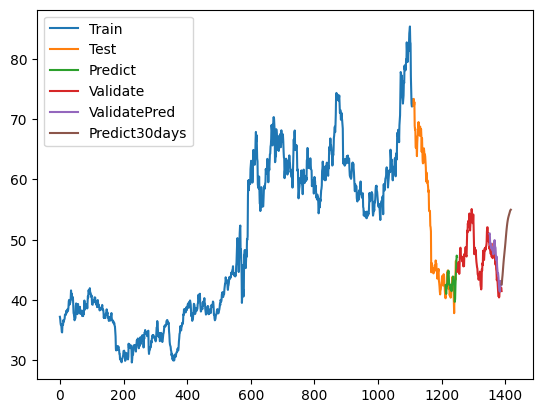

In [444]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

## Exponential Smoothing (ETS)

In [445]:
# 4. Split train test
data = data[['Close']]
data = data.dropna() # Drop missing values
data = data.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.8 * len(data))
test_size = int(0.1 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [446]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

In [447]:
pip install sktime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [448]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

In [449]:
simple_exp = ExponentialSmoothing(trend=None, seasonal=None)

In [450]:
#5. Fit model with train data
simple_exp.fit(y_train)

ExponentialSmoothing()

In [451]:
# 6. Testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])

# 7. Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])

In [452]:
y_pred = simple_exp.predict(test_data.index)

In [453]:
y_pred_val= simple_exp.predict(val_data.index)

In [454]:
#8. Predict next 7 days
last_index =  data.index[-1]
fh = list(range(last_index,last_index+7))
y_next_7_days = simple_exp.predict(fh)
y_next_7_days

array([[72.30999757],
       [72.30999757],
       [72.30999757],
       [72.30999757],
       [72.30999757],
       [72.30999757],
       [72.30999757]])

In [455]:
#9. Predict next 30 days
last_index =  data.index[-1]
fh = list(range(last_index,last_index+30))
y_next_30_days = simple_exp.predict(fh)
y_next_30_days

array([[72.30999757],
       [72.30999757],
       [72.30999757],
       [72.30999757],
       [72.30999757],
       [72.30999757],
       [72.30999757],
       [72.30999757],
       [72.30999757],
       [72.30999757],
       [72.30999757],
       [72.30999757],
       [72.30999757],
       [72.30999757],
       [72.30999757],
       [72.30999757],
       [72.30999757],
       [72.30999757],
       [72.30999757],
       [72.30999757],
       [72.30999757],
       [72.30999757],
       [72.30999757],
       [72.30999757],
       [72.30999757],
       [72.30999757],
       [72.30999757],
       [72.30999757],
       [72.30999757],
       [72.30999757]])

In [456]:
# 10. Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))

print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
valid_mae = mean_absolute_error(y_val, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 23.284570045629792
Validation RMSE: 25.198350884335397
Testing MAE: 20.668621043318055
Validation MAE: 24.966354732418736
Testing MAPE: 0.45692498421824373
Validation MAPE: 0.5353065509662143


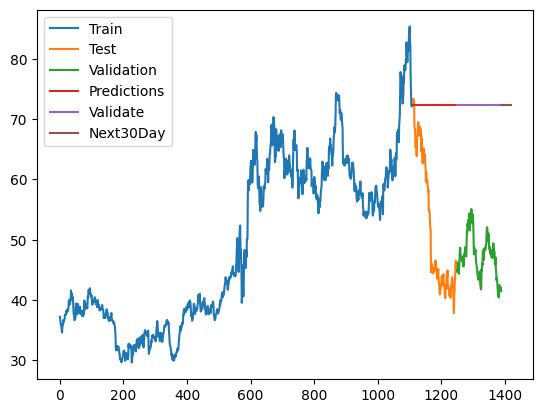

In [457]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(range(last_index+1, last_index+31),y_next_30_days)
plt.legend(['Train', 'Test', 'Validation', 'Predictions','Validate','Next30Day'])
plt.show()

## Random Forest

In [458]:
from sklearn.ensemble import RandomForestRegressor

In [459]:
data = data[['Close']]
data = data.dropna() # Drop missing values
data = data.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.8 * len(data))
test_size = int(0.1 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [460]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

In [461]:
# Testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])

# Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])

In [462]:
model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
model.fit(x_train, y_train)

RandomForestRegressor(max_depth=5, random_state=42)

In [463]:
y_pred = model.predict(x_test)

In [464]:
y_pred_val =  model.predict(x_val)

In [465]:
last_index =  data.index[-1]
# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(x_next_30_days)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[72.67420863 72.67420863 72.67420863 72.67420863 72.67420863 72.67420863
 72.67420863 72.67420863 72.67420863 72.67420863 72.67420863 72.67420863
 72.67420863 72.67420863 72.67420863 72.67420863 72.67420863 72.67420863
 72.67420863 72.67420863 72.67420863 72.67420863 72.67420863 72.67420863
 72.67420863 72.67420863 72.67420863 72.67420863 72.67420863 72.67420863]


In [466]:
# Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))

print('Testing RMSE:', test_rmse.item())
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
valid_mae = mean_absolute_error(y_val, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 23.60808554025345
Validation RMSE: 25.559256293364225
Testing MAE: 21.021840500812527
Validation MAE: 25.33056579717002
Testing MAPE: 0.46411119084764496
Validation MAPE: 0.543039584467307


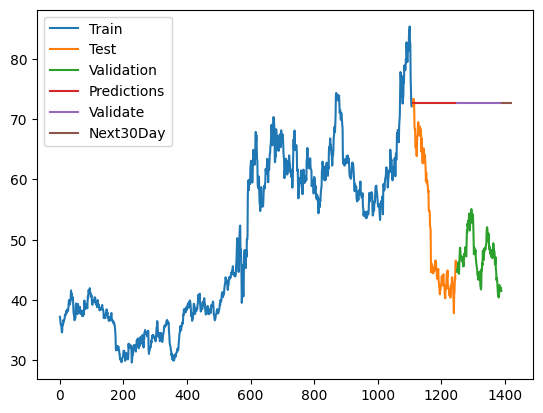

In [467]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(range(last_index+1, last_index+31),y_next_30_days)
plt.legend(['Train', 'Test', 'Validation', 'Predictions','Validate','Next30Day'])
plt.show()

## Bayesian Neural Networks (BNN)

In [468]:
# Split the data into training, testing, and validation sets
train_size = int(0.8 * len(data))
test_size = int(0.1 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [469]:
train_dates = train_data.index.values
test_dates = test_data.index.values
val_dates = val_data.index.values
train_close_prices = train_data['Close'].values
val_close_prices = val_data['Close'].values
test_close_prices = test_data['Close'].values

In [470]:
import torch
import torch.nn as nn

In [471]:
X_train = torch.from_numpy(train_dates.reshape(-1, 1)).float()
y_train = torch.from_numpy(train_close_prices.reshape(-1, 1)).float()
X_test = torch.from_numpy(test_dates.reshape(-1, 1)).float()
y_test = torch.from_numpy(test_close_prices.reshape(-1, 1)).float()
X_val = torch.from_numpy(val_dates.reshape(-1, 1)).float()
y_val = torch.from_numpy(val_close_prices.reshape(-1, 1)).float()

In [472]:
# Determining the architecture of a Bayesian Neural Network.
class BNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(BNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [473]:
# Determining the loss function and optimization algorithm.
criterion = nn.MSELoss()
learning_rate = 0.001
num_epochs = 1000

In [474]:
# Built model BNN
model = BNN(input_size=1, output_size=1)

In [475]:
# Train model BNN
for epoch in range(num_epochs):
    model.train()

    # Tính đầu ra dự đoán của mô hình
    y_pred = model(X_train)

    # Tính lỗi dự đoán so với giá thực tế
    loss = criterion(y_pred, y_train)

    # Backpropagation và cập nhật trọng số
    loss.backward()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

Epoch [100/1000], Loss: 287.7593994140625
Epoch [200/1000], Loss: 346.435546875
Epoch [300/1000], Loss: 377.111572265625
Epoch [400/1000], Loss: 535.7472534179688
Epoch [500/1000], Loss: 376.1434326171875
Epoch [600/1000], Loss: 282.0829772949219
Epoch [700/1000], Loss: 349.287353515625
Epoch [800/1000], Loss: 299.0583801269531
Epoch [900/1000], Loss: 270.05963134765625
Epoch [1000/1000], Loss: 500.7320556640625


In [476]:
# Test
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test)

In [477]:
# Validation
model.eval()
with torch.no_grad():
    y_pred_val = model(X_val)

In [478]:
y_test = np.array(test_data['Close'])
y_val = np.array(val_data['Close'])

In [479]:
# Evaluating algorithm accuracy using
#RMSE
test_rmse = torch.sqrt(torch.mean((y_pred_test - y_test)**2))
valid_rmse = torch.sqrt(torch.mean((y_pred_val - y_val)**2))
#test_rmse = np.sqrt(np.mean((y_pred_test - y_test)**2))
#valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))

print('Testing RMSE:', test_rmse.item())
print('Validation RMSE:', valid_rmse.item())

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred_test)
valid_mae = mean_absolute_error(y_val, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred_test)
valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 67.15302933501967
Validation RMSE: 84.20811816589669
Testing MAE: 66.16992864746979
Validation MAE: 84.04664091382708
Testing MAPE: 1.386986488483274
Validation MAPE: 1.7919512209764934


In [480]:
# Predict the next 7 days
last_index =  data.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+7, step=1)

x_next_7_days = torch.from_numpy(np.array(range(last_index+1, last_index+8)).reshape(-1, 1)).float()

model.eval()
with torch.no_grad():
    y_pred_next = model(x_next_7_days)

# Chuyển đổi kết quả dự đoán thành mảng numpy
y_pred_next = y_pred_next.numpy().flatten()

# Hiển thị kết quả dự đoán
for i in range(len(x_next_7_days)):
    print(f'{y_pred_next[i]}')

138.26519775390625
138.36270141601562
138.46022033691406
138.55772399902344
138.65524291992188
138.7527618408203
138.85028076171875


In [481]:
# Predict the next 30 days
last_index =  data.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = torch.from_numpy(np.array(range(last_index+1, last_index+31)).reshape(-1, 1)).float()

model.eval()
with torch.no_grad():
    y_pred_next = model(x_next_30_days)

# Chuyển đổi kết quả dự đoán thành mảng numpy
y_pred_next = y_pred_next.numpy().flatten()

# Hiển thị kết quả dự đoán
for i in range(len(x_next_30_days)):
    print(f'{y_pred_next[i]}')

138.26519775390625
138.36270141601562
138.46022033691406
138.55772399902344
138.65524291992188
138.7527618408203
138.85028076171875
138.9477996826172
139.04531860351562
139.14283752441406
139.2403564453125
139.33787536621094
139.4353790283203
139.53289794921875
139.6304168701172
139.72793579101562
139.82545471191406
139.9229736328125
140.02047729492188
140.1179962158203
140.21551513671875
140.3130340576172
140.41055297851562
140.508056640625
140.6055908203125
140.70309448242188
140.8006134033203
140.89813232421875
140.9956512451172
141.09317016601562


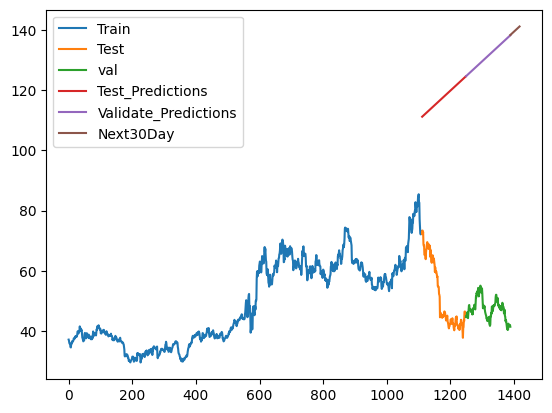

In [482]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred_test)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data, y_pred_next)
plt.legend(['Train', 'Test','val', 'Test_Predictions','Validate_Predictions','Next30Day'])
plt.show()

## Gaussian Process Regression (GPR)

In [483]:
# Split the data into training, testing, and validation sets
train_size = int(0.8 * len(data))
test_size = int(0.1 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [484]:
# Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

In [485]:
# Testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])

# Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])

In [486]:
# Choose best kernel
kernels = [RBF(), Matern(), RationalQuadratic(), ExpSineSquared(), DotProduct()]
param_grid = {'kernel': kernels}

gpr = GaussianProcessRegressor()
grid_search = GridSearchCV(gpr, param_grid, cv=KFold(n_splits=5))

grid_search.fit(x_train, y_train)


print("Best Kernel:", grid_search.best_estimator_.kernel)
print("Best Score:", grid_search.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter periodicity is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter periodicity is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The 

Best Kernel: RationalQuadratic(alpha=1, length_scale=1)
Best Score: -1.20533020923811


In [487]:
# Built model GPR
kernel = RationalQuadratic(alpha=1, length_scale=1)
gpr = GaussianProcessRegressor(kernel=kernel, random_state=42)

In [488]:
gpr.fit(x_train, y_train)

GaussianProcessRegressor(kernel=RationalQuadratic(alpha=1, length_scale=1),
                         random_state=42)

In [489]:
y_pred = gpr.predict(x_test)

In [490]:
y_pred_val =  gpr.predict(x_val)

In [491]:
# 12. Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))

print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
valid_mae = mean_absolute_error(y_val, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 10.12581326323417
Validation RMSE: 5.120663088095872
Testing MAE: 8.65705146632602
Validation MAE: 4.340822911409258
Testing MAPE: 0.19327064695676915
Validation MAPE: 0.09580047699018776


In [492]:
# Predict the next 7 days
last_index =  data.index[-1]
# Create an array of 7 consecutive integers starting from last_index
x_next_7_days = np.array(range(last_index+1, last_index+8)).reshape(-1, 1)

# Predict the closing prices for the next 7 days
y_next_7_days = gpr.predict(x_next_7_days)

# Print the predicted closing prices for the next 7 days
print('Predicted closing prices for the next 7 days:')
print(y_next_7_days)

Predicted closing prices for the next 7 days:
[49.33995965 49.31714668 49.29441335 49.27175914 49.24918352 49.22668596
 49.20426594]


In [493]:
# Predict the next 30 days
last_index =  data.index[-1]
# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = gpr.predict(x_next_30_days)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[49.33995965 49.31714668 49.29441335 49.27175914 49.24918352 49.22668596
 49.20426594 49.18192294 49.15965647 49.13746601 49.11535106 49.09331113
 49.07134573 49.04945438 49.02763659 49.00589189 48.98421981 48.96261988
 48.94109164 48.91963464 48.89824842 48.87693253 48.85568653 48.83450998
 48.81340245 48.79236349 48.77139269 48.75048962 48.72965386 48.708885  ]


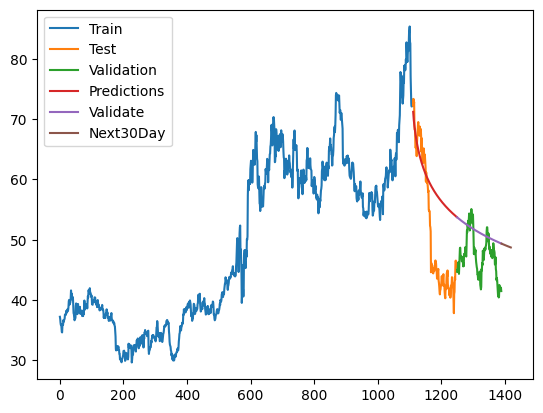

In [494]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(range(last_index+1, last_index+31),y_next_30_days)
plt.legend(['Train', 'Test', 'Validation', 'Predictions','Validate','Next30Day'])
plt.show()

## Recurrent Neural Network (RNN)

In [495]:
df1=df.reset_index()['Close']

In [496]:
#Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [497]:
# Split train test
train_size = int(0.8 * len(df1))
test_size = int(0.1 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [498]:
# Function Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [499]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [500]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [501]:
from keras.layers import Dense, SimpleRNN

In [502]:
# 8. Define RNN Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [503]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
16/16 [==============================] - 5s 104ms/step - loss: 0.0603 - val_loss: 0.0054
Epoch 2/100
16/16 [==============================] - 1s 52ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 3/100
16/16 [==============================] - 1s 51ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 4/100
16/16 [==============================] - 1s 60ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 5/100
16/16 [==============================] - 1s 49ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 6/100
16/16 [==============================] - 1s 88ms/step - loss: 9.8359e-04 - val_loss: 0.0013
Epoch 7/100
16/16 [==============================] - 2s 96ms/step - loss: 9.1491e-04 - val_loss: 0.0012
Epoch 8/100
16/16 [==============================] - 2s 113ms/step - loss: 8.6063e-04 - val_loss: 0.0011
Epoch 9/100
16/16 [==============================] - 1s 91ms/step - loss: 8.5378e-04 - val_loss: 0.0011
Epoch 10/100
16/16 [==============================] - 1s 54ms/step - loss: 8.2312e

In [504]:
# Test, val
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 12ms/step


In [505]:
# Chuẩn hóa dữ liệu y_pred, y_pred_val
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [506]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

yval = scaler.inverse_transform(yval.reshape(-1,1))

In [507]:
# Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))

print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(ytest, y_pred)
valid_mae = mean_absolute_error(yval, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(ytest, y_pred)
valid_mape = mean_absolute_percentage_error(yval, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 1.3088389046283544
Validation RMSE: 0.9371547802481568
Testing MAE: 1.0053181003879856
Validation MAE: 0.7043834588466547
Testing MAPE: 0.023720601262416985
Validation MAPE: 0.015454734172872256


In [508]:
# Predict the next 7 days
x_input=val_data[39:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<7):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.39286993 0.40970981 0.42529561 0.43049089 0.42619133 0.45664638
 0.43944826 0.4249373  0.4145468  0.41795057 0.4405231  0.40899321
 0.36277318 0.32246504 0.34252959 0.33590109 0.32210681 0.32927266
 0.33500537 0.31189535 0.29917591 0.29111427 0.28341094 0.27893225
 0.26209244 0.26262986 0.2497313  0.24614834 0.25098532 0.2597635
 0.25689715 0.27051238 0.26191332 0.23109997 0.22500896 0.2174848
 0.22500896 0.27803653 0.27355785 0.29577214 0.28986025 0.33267643
 0.32640631 0.30455032 0.30526692 0.32586889 0.33948405 0.33339304
 0.34145468 0.33572197 0.34467934 0.34790399 0.35596563 0.38964527
 0.40254389 0.40218559 0.38498747 0.36402721 0.36026513 0.38373345
 0.35686136 0.33805091 0.34503764 0.33428876 0.32748121 0.32282335
 0.32998927 0.33321392 0.31440347 0.33446795 0.31888215 0.31046221
 0.33070587 0.32049448 0.35489072 0.34252959 0.33482625 0.3323182
 0.32622719 0.29165176 0.2927266  0.31332856 0.27803653 0.2714081
 0.24489431 0.25188105 0.24596922 0.23092085 0.2187388

In [509]:
scaler.inverse_transform(lst_output)

array([[40.77114761],
       [40.39928249],
       [40.52497069],
       [40.69617654],
       [40.5960615 ],
       [40.28808228],
       [40.36852898]])

In [510]:
# Predict the next 30 days
x_input=val_data[39:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.39286993 0.40970981 0.42529561 0.43049089 0.42619133 0.45664638
 0.43944826 0.4249373  0.4145468  0.41795057 0.4405231  0.40899321
 0.36277318 0.32246504 0.34252959 0.33590109 0.32210681 0.32927266
 0.33500537 0.31189535 0.29917591 0.29111427 0.28341094 0.27893225
 0.26209244 0.26262986 0.2497313  0.24614834 0.25098532 0.2597635
 0.25689715 0.27051238 0.26191332 0.23109997 0.22500896 0.2174848
 0.22500896 0.27803653 0.27355785 0.29577214 0.28986025 0.33267643
 0.32640631 0.30455032 0.30526692 0.32586889 0.33948405 0.33339304
 0.34145468 0.33572197 0.34467934 0.34790399 0.35596563 0.38964527
 0.40254389 0.40218559 0.38498747 0.36402721 0.36026513 0.38373345
 0.35686136 0.33805091 0.34503764 0.33428876 0.32748121 0.32282335
 0.32998927 0.33321392 0.31440347 0.33446795 0.31888215 0.31046221
 0.33070587 0.32049448 0.35489072 0.34252959 0.33482625 0.3323182
 0.32622719 0.29165176 0.2927266  0.31332856 0.27803653 0.2714081
 0.24489431 0.25188105 0.24596922 0.23092085 0.2187388

In [511]:
scaler.inverse_transform(lst_output)

array([[40.77114761],
       [40.39928249],
       [40.52497069],
       [40.69617654],
       [40.5960615 ],
       [40.28808228],
       [40.36852898],
       [40.48686589],
       [40.03750771],
       [39.81240982],
       [39.71762651],
       [39.7557729 ],
       [38.98481257],
       [38.77540876],
       [38.4813594 ],
       [38.13291561],
       [37.96909849],
       [37.42864596],
       [37.75095098],
       [37.67165629],
       [37.45877397],
       [36.95996714],
       [36.5686437 ],
       [36.32281612],
       [36.07810937],
       [35.94826391],
       [35.92717739],
       [35.88633477],
       [35.73164148],
       [35.61855894]])

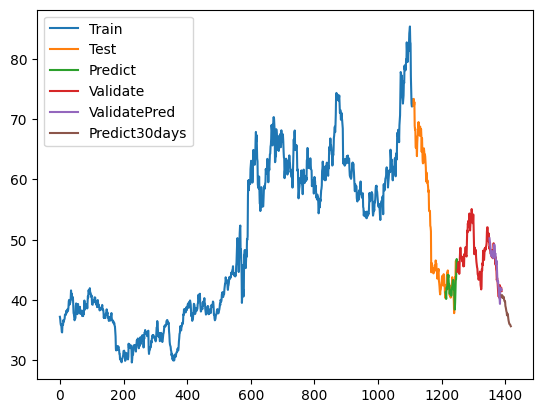

In [512]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()